Trains and  tests on parts of  NA12878 data for Del_st, Del_end and No_sv, ground  truth Mills_nanosv. NoSV is windows nnot called by any caller. 

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [2]:
import pickle
dico = pickle.load(open("F:/1_GTCG/data/09112018/TestData_091118/NA12878/MultiLabelData/labels.pickle", "rb"))
data_labels = dataset = dico["Mills2011_nanosv"]
window_size = 200

In [3]:
print(dico.keys())

dict_keys(['lumpy', 'id', 'Mills2011_PacBio_Moleculo_nanosv', 'Mills2011_nanosv', 'gridss', 'nanosv_manta', 'Mills2011_PacBio_Moleculo', 'Mills2011_PacBio_Moleculo_Lumpy_GASVPro_DELLY_Pindel', 'delly', 'nanosv', 'nanosv_Mills2011', 'Mills2011_nanosv_manta', 'Mills2011_PacBio_Moleculo_nanosv_manta', 'manta', 'Mills2011', 'nanosv_Mills2011_PacBio_Moleculo'])


In [4]:
dico = []

In [5]:
replications = 64
factor_nosv = 1 # factor_nosv times less Nosv than del-st

In [6]:
#datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 
datapath = 'F:/1_GTCG/data/09112018/TestData_091118/NA12878/ChannelData/'
germline_1_datapath = datapath # '/ChannelData/unzipped/'
#ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 38, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 38, window_size])
G1_labels_noSV =[]
total_train_sv_windows = 0
for i in range(1,23,1):
        G1_data_new =np.load(germline_1_datapath + 'NA12878_' + str(i) + '.npy')
        #G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_labels_new = np.array(data_labels[str(i)])
        print(G1_labels_new[0])
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        G1_data_noSV_new =  G1_data_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]# 4 times less than del_st to boost recall
        G1_labels_noSV_new =  G1_labels_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)] # also
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        #print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))
        if i < 16: #for training until chromozome 16
            total_train_sv_windows += G1_data_SV_new.shape[0]

noSV
1:(222, 38, 200)
noSV
2:(205, 38, 200)
noSV
3:(208, 38, 200)
noSV
4:(228, 38, 200)
noSV
5:(214, 38, 200)
noSV
6:(162, 38, 200)
noSV
7:(163, 38, 200)
noSV
8:(135, 38, 200)
noSV
9:(127, 38, 200)
noSV
10:(107, 38, 200)
noSV
11:(119, 38, 200)
noSV
12:(114, 38, 200)
noSV
13:(106, 38, 200)
noSV
14:(66, 38, 200)
noSV
15:(61, 38, 200)
noSV
16:(47, 38, 200)
noSV
17:(48, 38, 200)
noSV
18:(77, 38, 200)
noSV
19:(44, 38, 200)
noSV
20:(58, 38, 200)
noSV
21:(28, 38, 200)
noSV
22:(21, 38, 200)


### Find  the indexes that split the categories

In [7]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [49]:
#find_splitting_indices(G1_labels)

In [50]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [8]:
sv=G1_data_SV.shape[0]

sv

2560

In [9]:
int(sv/2)

nosv = G1_data_noSV.shape[0]
nosv

81920

In [55]:
#G1_data_noSV  = G1_data_noSV[0:2*sv] 

In [56]:
#G1_labels_noSV  = G1_labels_noSV[0:2*sv] 

In [10]:
def eliminate_noise_chanels(X):
    #return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    #return np.take(X,[0,1,2,3,4,5,6,7,8,27,28,36,37], axis = 1)
    return np.take(X,[0,1,2,27,28], axis = 1)

In [11]:
G1_data_noSV = eliminate_noise_chanels(G1_data_noSV)
G1_data_SV = eliminate_noise_chanels(G1_data_SV)

In [12]:
coverage = np.median(G1_data_noSV[:, 0, :]) #the median of the coverage in the normal cells
coverage

39.0

In [13]:
number_channels = G1_data_noSV.shape[1]

In [14]:
number_channels 

5

In [15]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(G1_data_noSV)
normalize(G1_data_SV)

In [76]:
def find_relevant_indices(X, threshold):# I tried to make it pythonic, failed many times, so here we go:
    indices = []
    k=0
    for i in X:
        found = 0
        for j in i[1]:
            if j > threshold:
                indices.append(k)
                found = 1
                break;
        if found ==0:
            for j in i[2]:
                if j > threshold:
                    indices.append(k)
                    found = 1
                    break;               
        k += 1                    
    return indices               

In [77]:
G1_data_SV[:,1,:].shape

(2560, 200)

In [88]:
indices = find_relevant_indices(G1_data_SV, 7)

In [89]:
len(indices)

2560

In [90]:
indices_noSV = find_relevant_indices(G1_data_noSV, 7)

In [91]:
len(indices_noSV)

18635

In [16]:
G1_data_SV.shape

(2560, 5, 200)

In [ ]:
sv=G1_data_SV.shape[0]

sv

int(sv/2)

nosv = G1_data_noSV.shape[0]
nosv

In [17]:
SV_train =  int(0.8 * total_train_sv_windows)
noSV_train = int(replications * SV_train / 2/factor_nosv)
SV_val = total_train_sv_windows - SV_train
noSV_val = int(replications * SV_val / 2/factor_nosv)

In [18]:
def replicate(data, start, end, howmanytimes): 
    X = data[start:end]
    for i in range(0,howmanytimes):
        X = np.concatenate((X, data[start:end]))
    return X    
    

In [19]:

X_train = replicate(G1_data_SV, 0, SV_train, replications)
#y_train = replicate(G1_labels_SV, 0, SV_train,replications)
X_val = replicate(G1_data_SV, SV_train, SV_train+SV_val, replications)
#y_val = replicate(G1_labels_SV, SV_train, SV_train+SV_val, replications)
X_test = replicate(G1_data_SV, SV_train+SV_val, len(G1_data_SV), replications)
#y_test = replicate(G1_labels_SV, SV_train+SV_val, len(G1_labels_SV), replications)

In [20]:
X_train = np.concatenate((X_train, G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((X_val, G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((X_test, G1_data_noSV[noSV_train +noSV_val:]))

In [21]:
y_train = replicate(G1_labels_SV, 0, SV_train,replications)
y_val = replicate(G1_labels_SV, SV_train, SV_train+SV_val, replications)
y_test = replicate(G1_labels_SV, SV_train+SV_val, len(G1_labels_SV), replications)

In [22]:
y_train = np.concatenate((y_train, G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((y_val, G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((y_test, G1_labels_noSV[noSV_train +noSV_val:]))

### Number of training, validation and test windows

In [23]:
X_train.shape

(173533, 5, 200)

In [24]:
X_val.shape

(43456, 5, 200)

In [25]:
X_test.shape

(31331, 5, 200)

In [26]:
y_test.shape

(31331,)

In [27]:
number_channels = X_train.shape[1]
number_channels

5

## Differentiate the time series for a zero mean

In [210]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [34]:
#X_train = differentiate(X_train)

In [35]:
#X_val = differentiate(X_val)
#X_test = differentiate(X_test)

## Plots several  windows

In [211]:
n_windows = 100
label = ["None"] * number_channels

In [212]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [273]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        #if y_test[i] == labels[predicted[i]]:
            #continue
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Label:', y_test[i])#, '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Label: 1


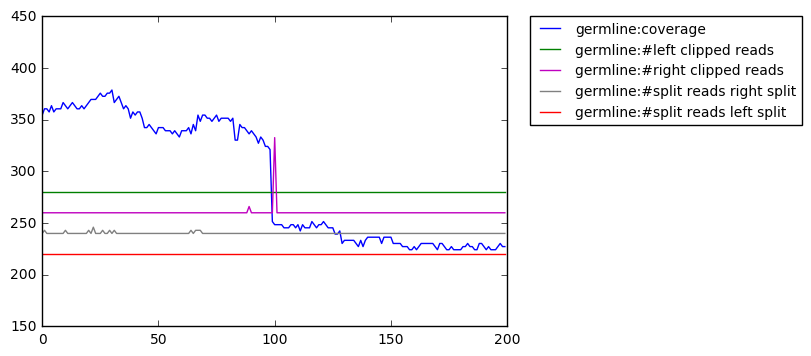

id: 1
Label: 0


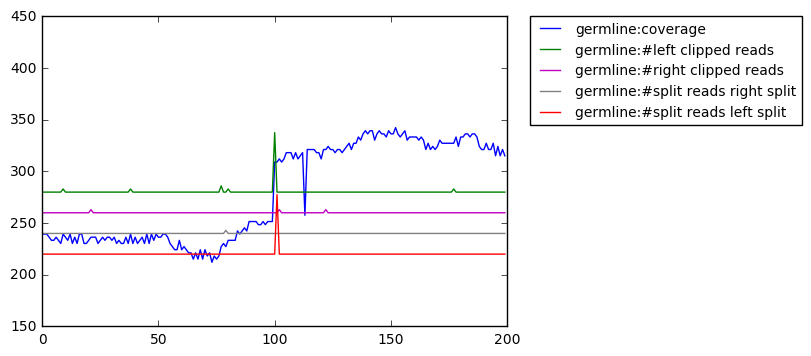

id: 2
Label: 1


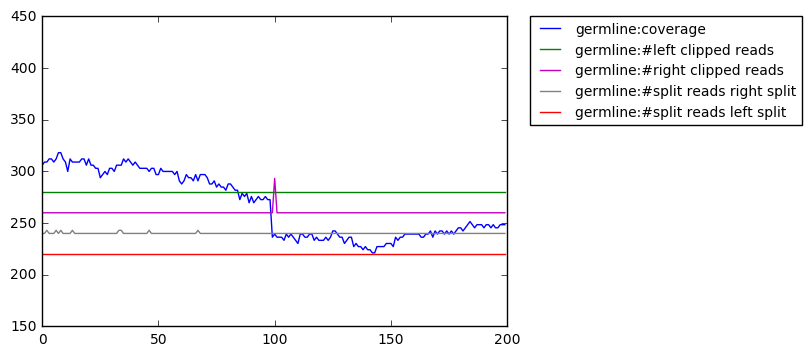

id: 3
Label: 0


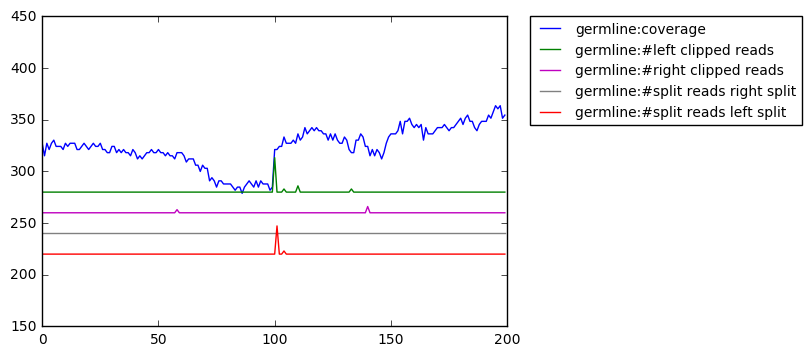

id: 4
Label: 0


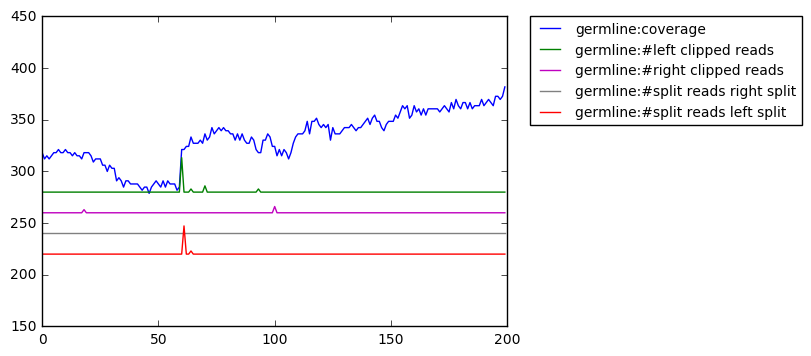

id: 5
Label: 1


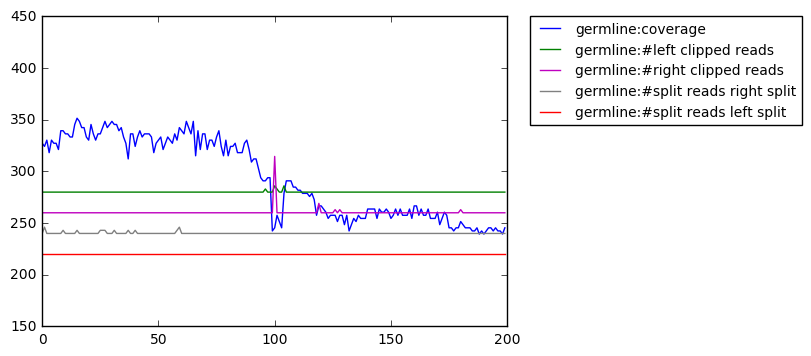

id: 6
Label: 1


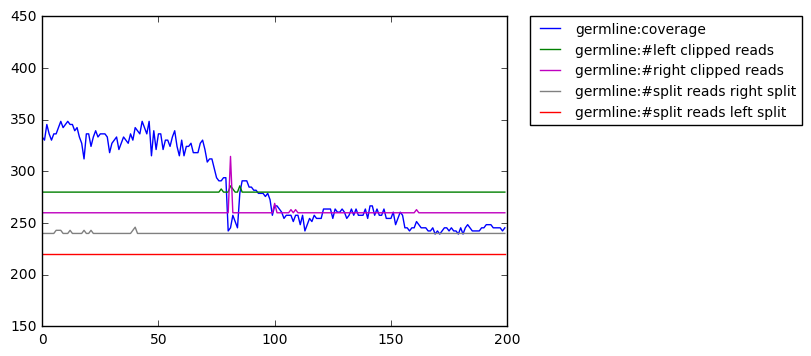

id: 7
Label: 0


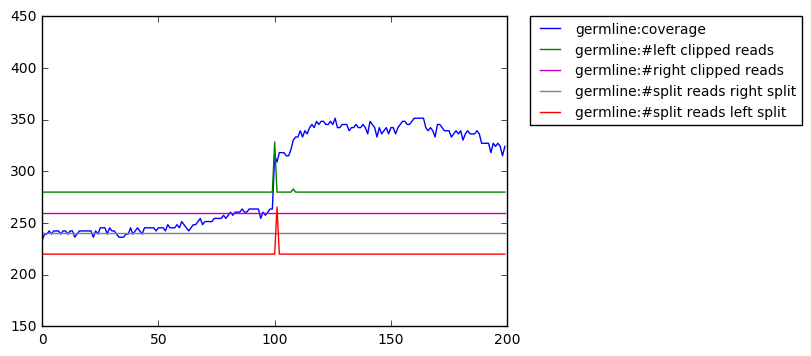

id: 8
Label: 1


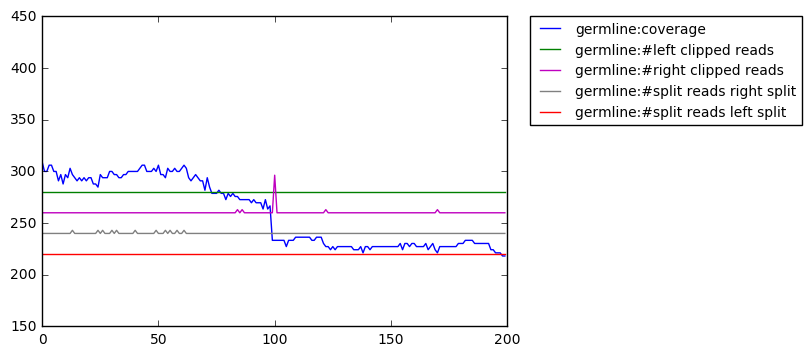

id: 9
Label: 0


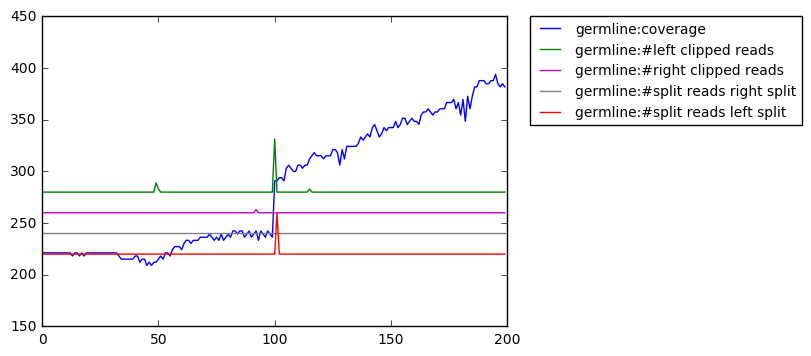

id: 10
Label: 1


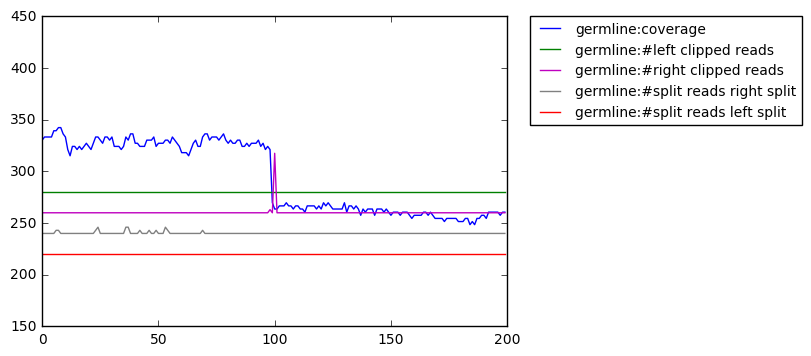

id: 11
Label: 1


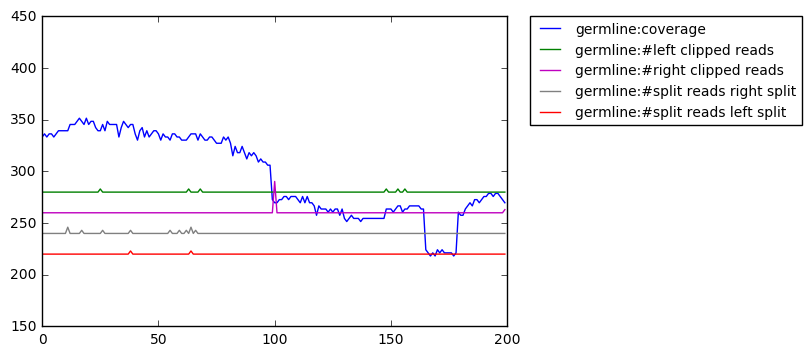

id: 12
Label: 0


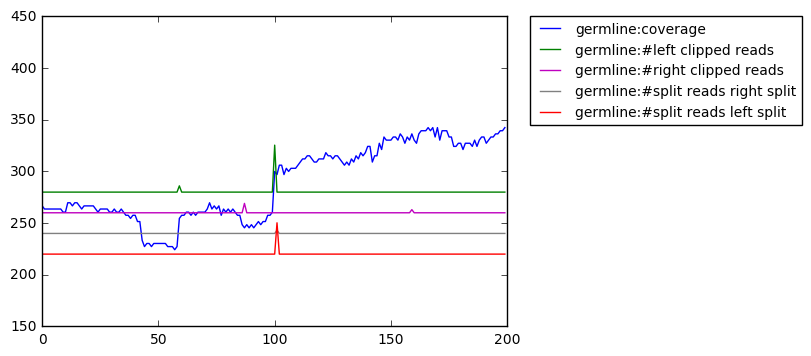

id: 13
Label: 1


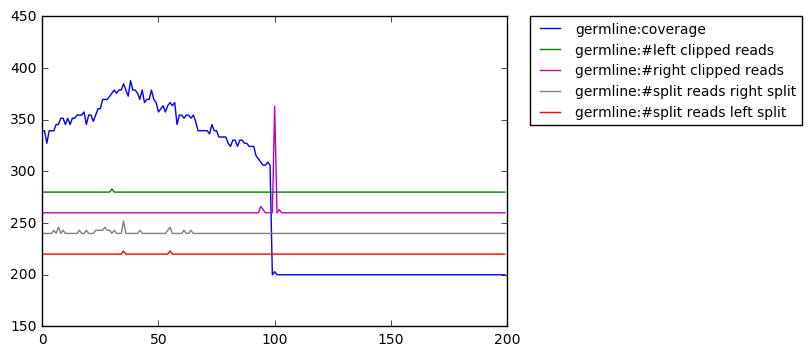

id: 14
Label: 0


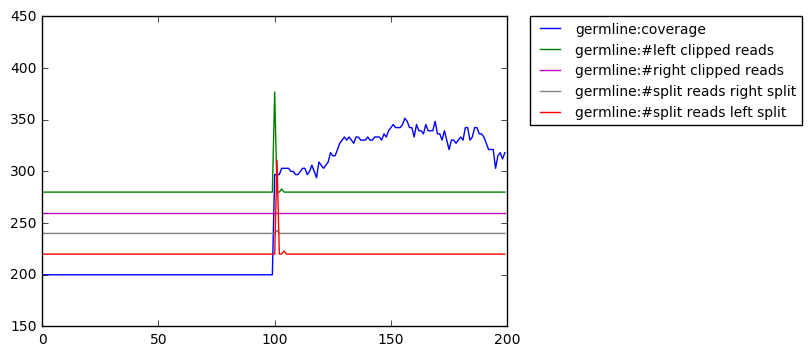

id: 15
Label: 1


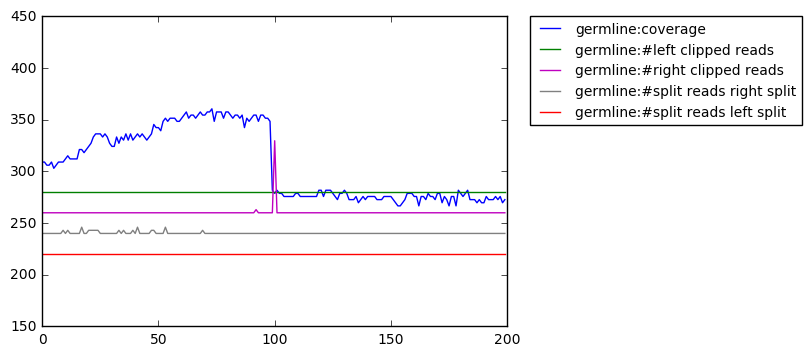

id: 16
Label: 1


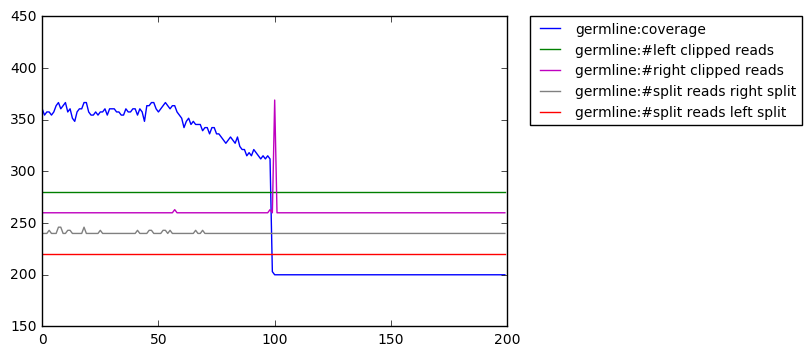

id: 17
Label: 0


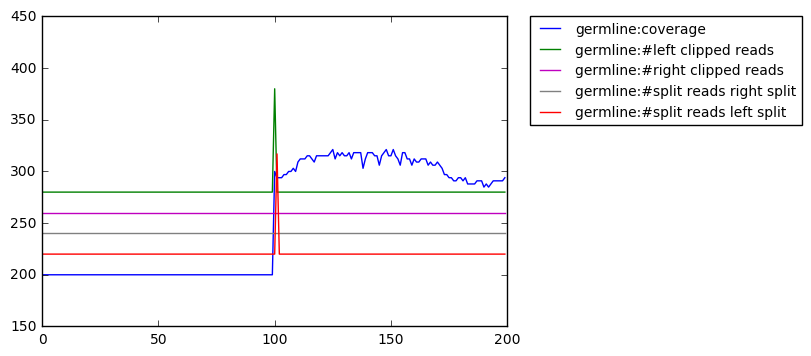

id: 18
Label: 1


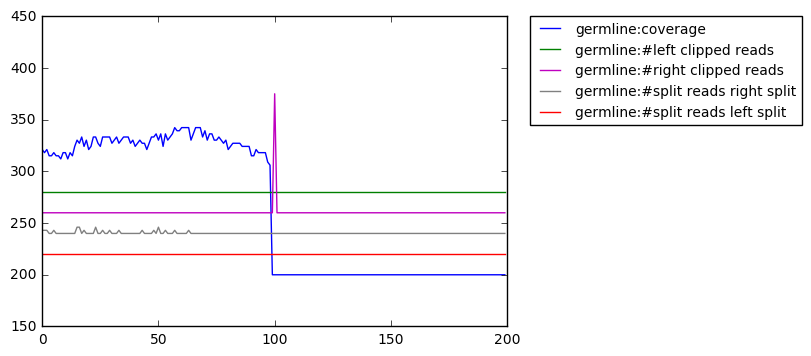

id: 19
Label: 0


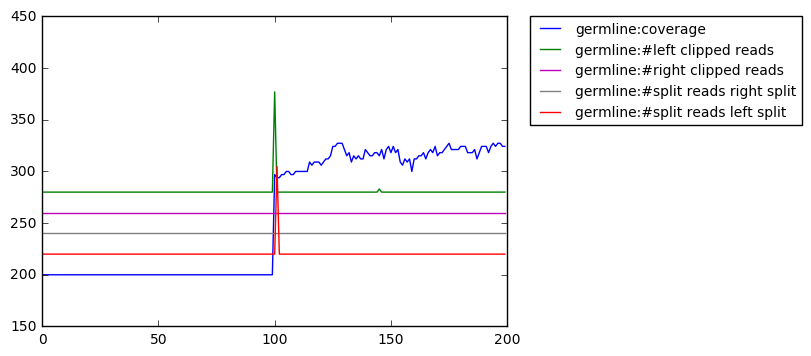

id: 20
Label: 1


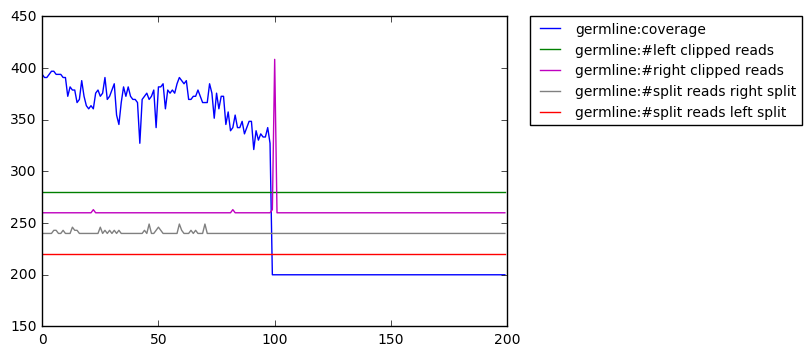

id: 21
Label: 1


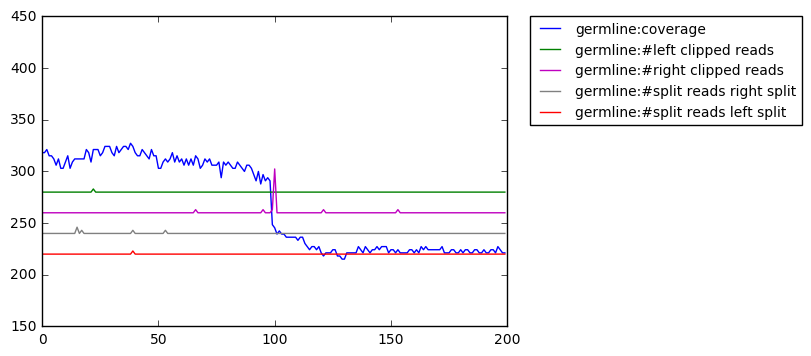

id: 22
Label: 0


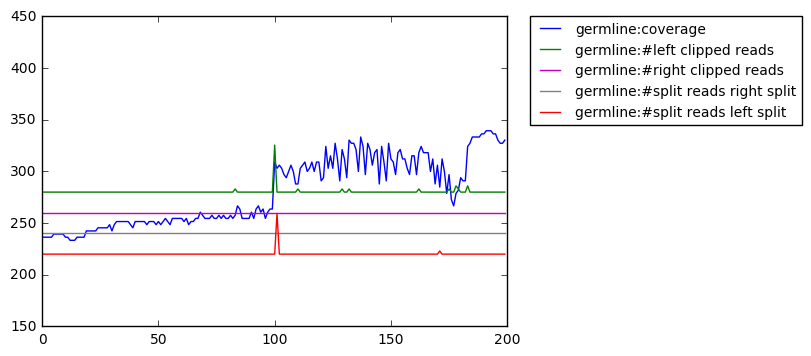

id: 23
Label: 1


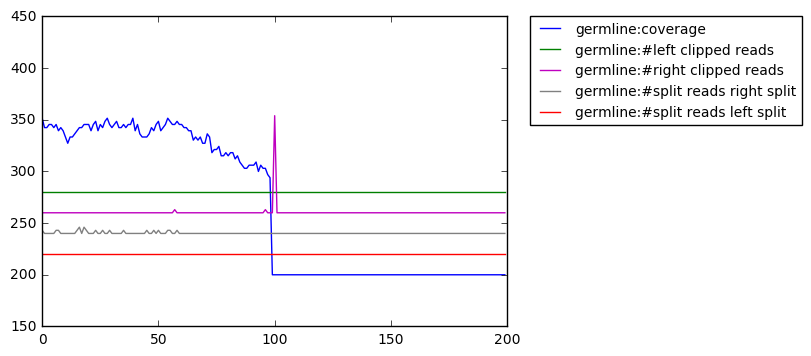

id: 24
Label: 0


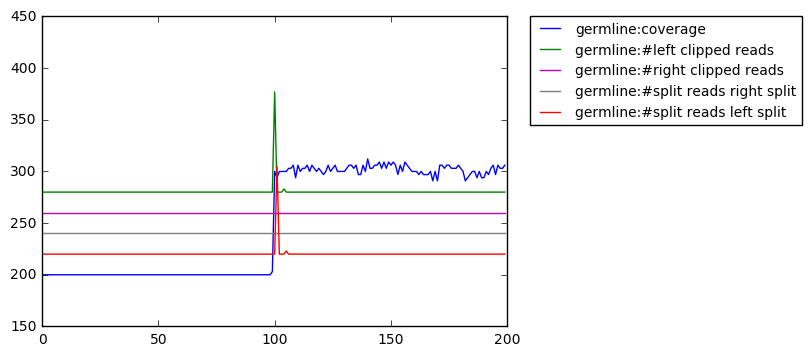

id: 25
Label: 1


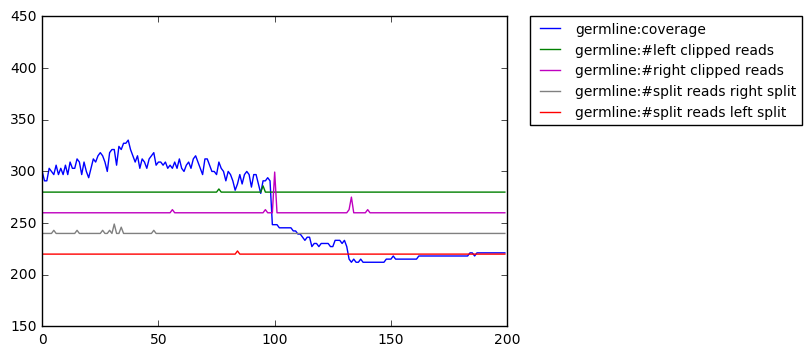

id: 26
Label: 0


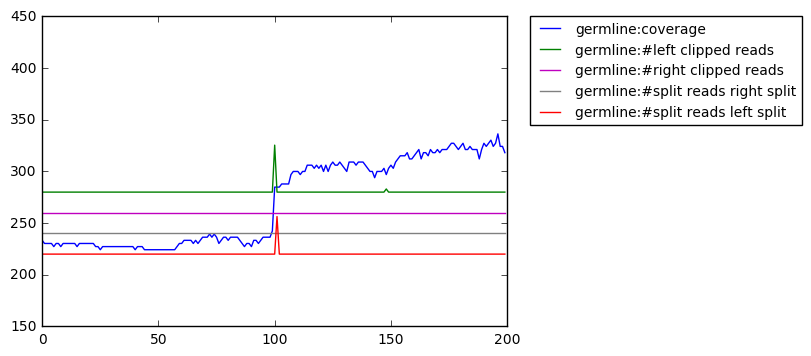

id: 27
Label: 1


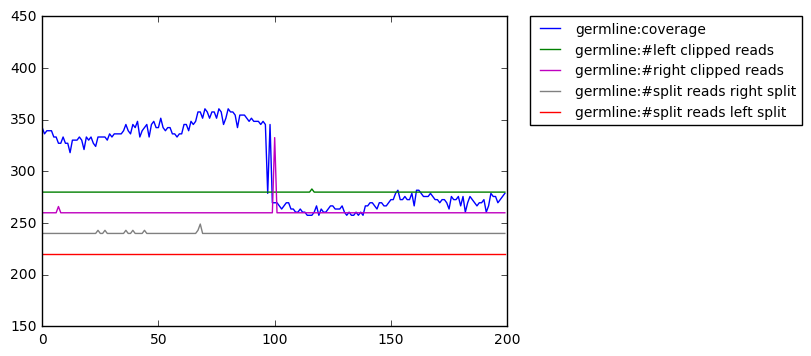

id: 28
Label: 1


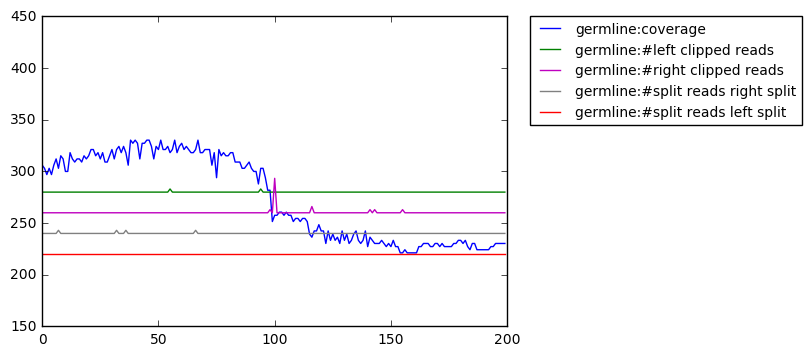

id: 29
Label: 1


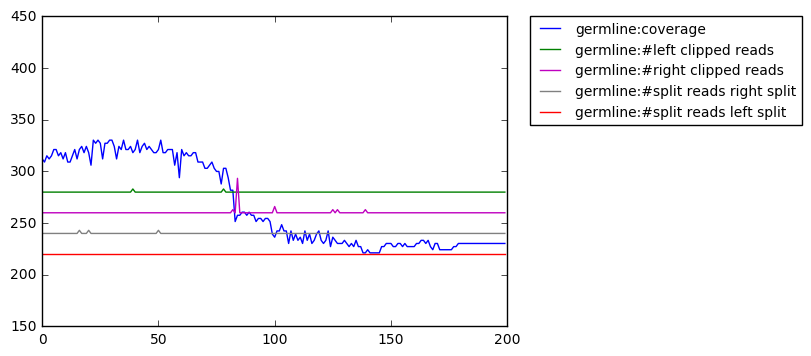

id: 30
Label: 0


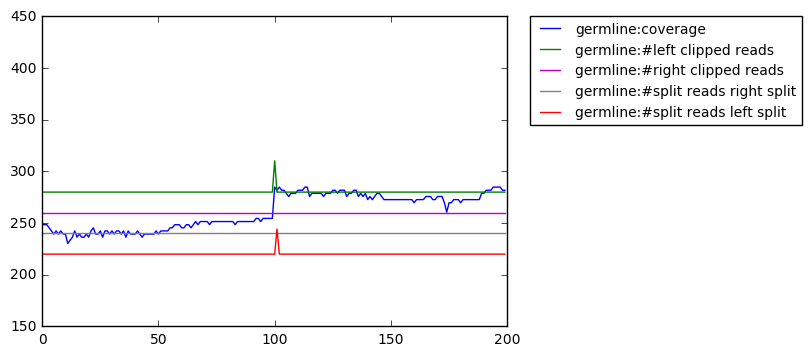

id: 31
Label: 1


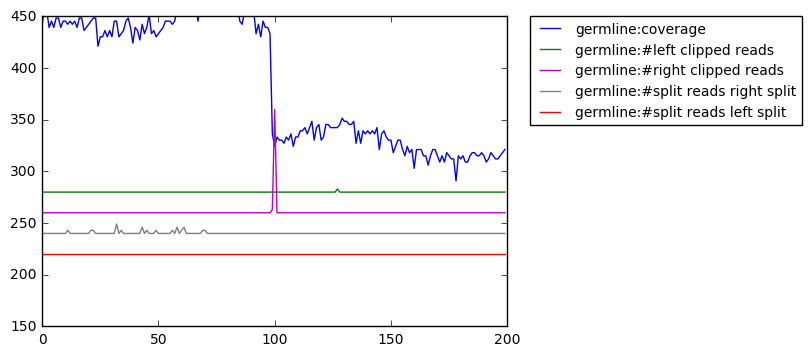

id: 32
Label: 0


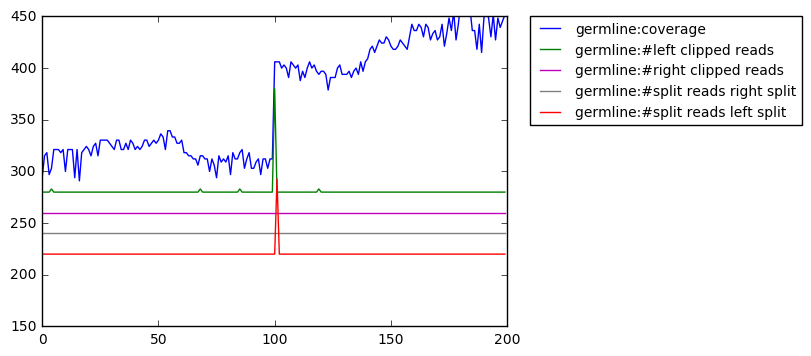

id: 33
Label: 1


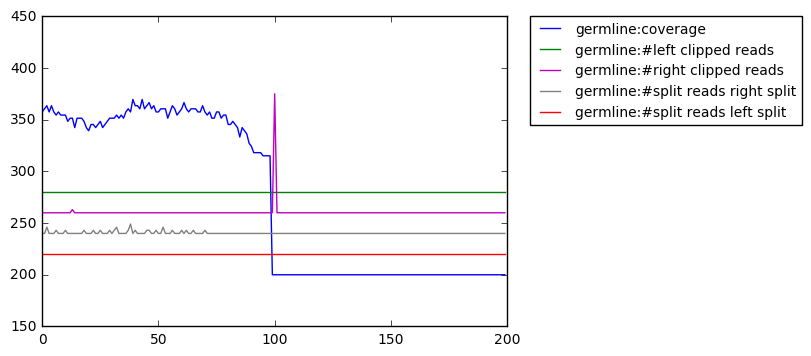

id: 34
Label: 0


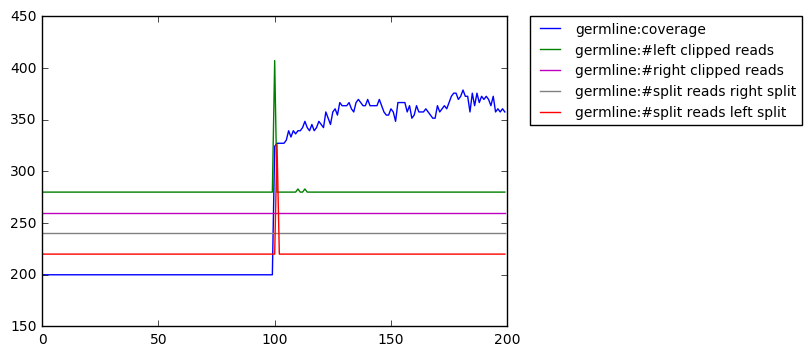

id: 35
Label: 0


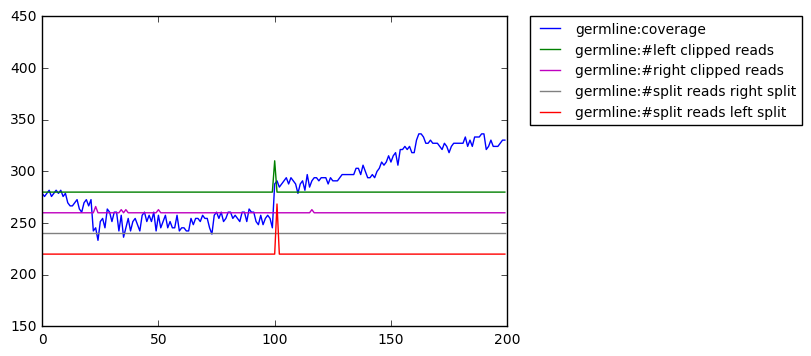

id: 36
Label: 1


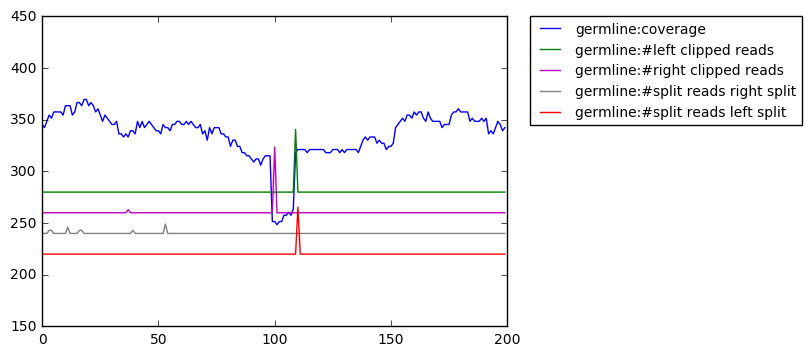

id: 37
Label: 1


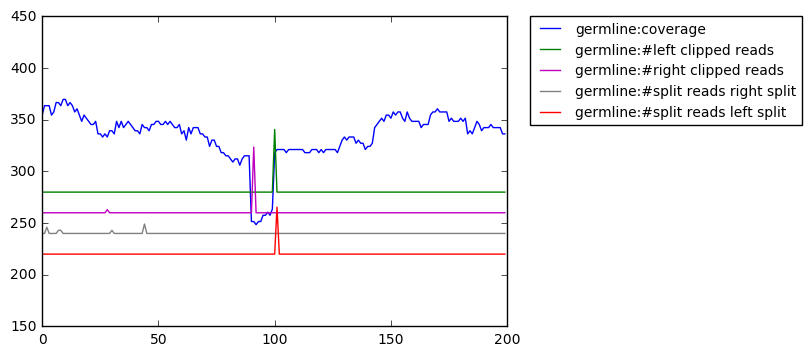

id: 38
Label: 0


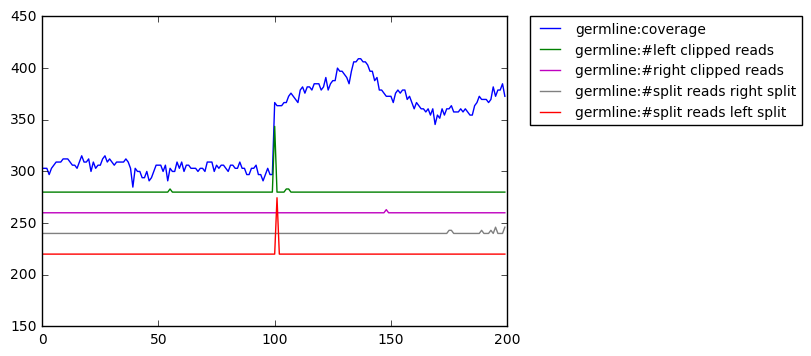

id: 39
Label: 1


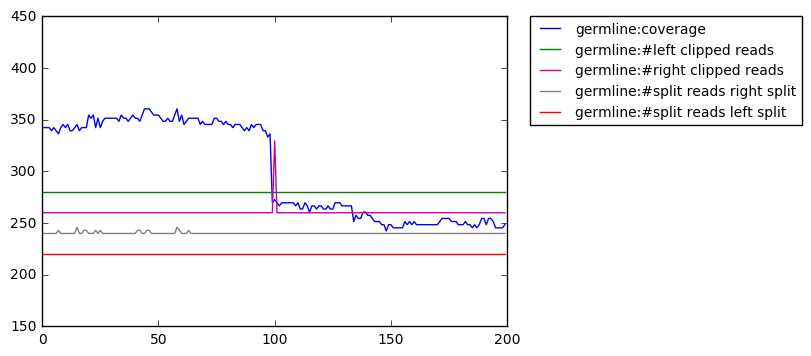

id: 40
Label: 1


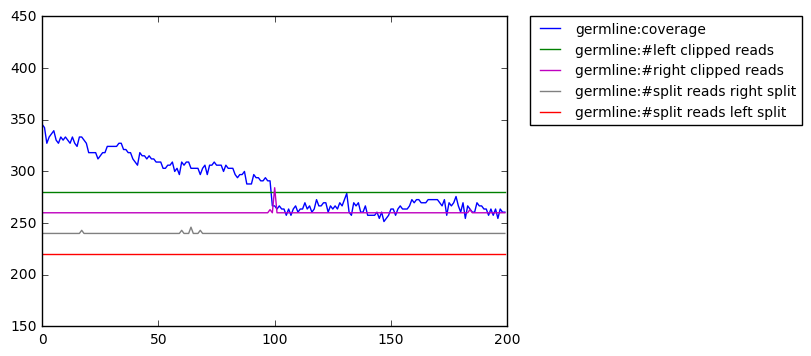

id: 41
Label: 1


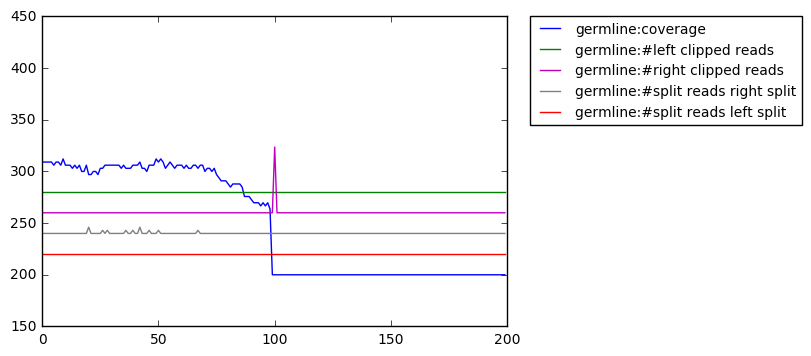

id: 42
Label: 0


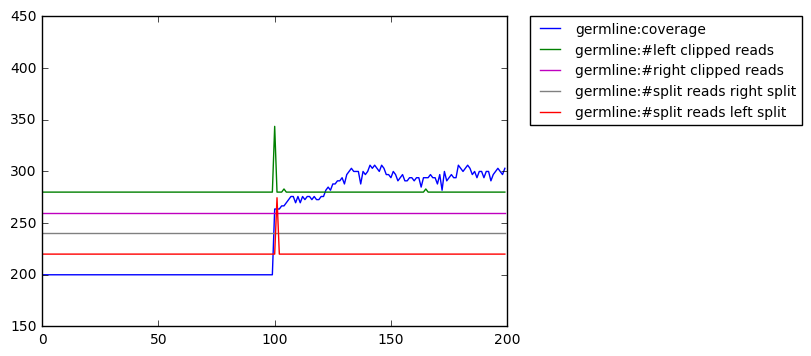

id: 43
Label: 0


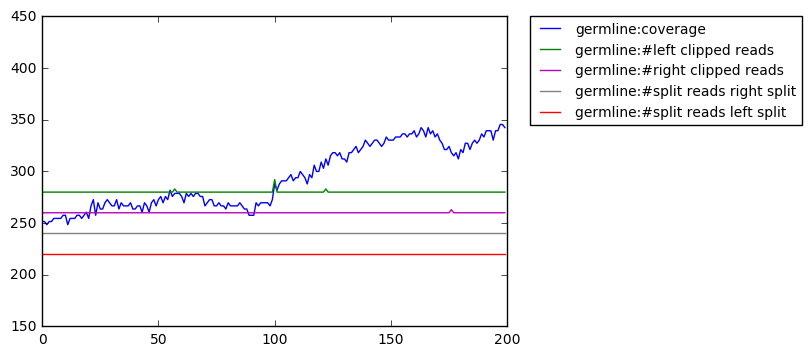

id: 44
Label: 1


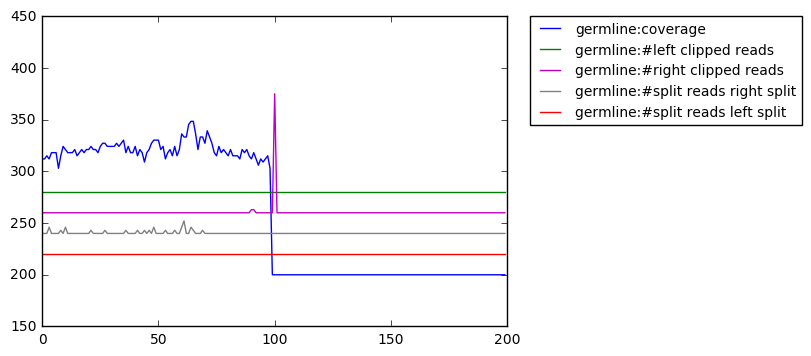

id: 45
Label: 0


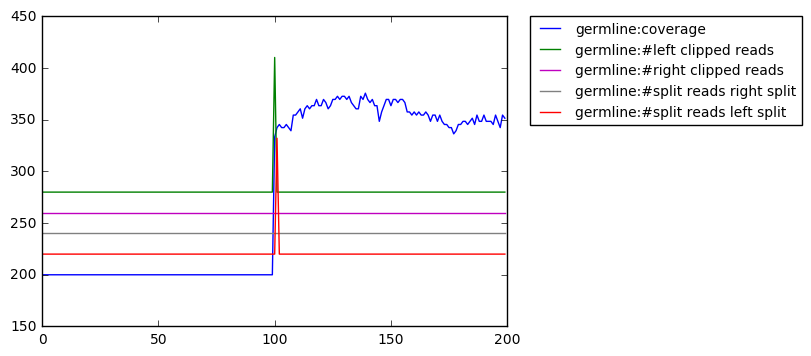

id: 46
Label: 1


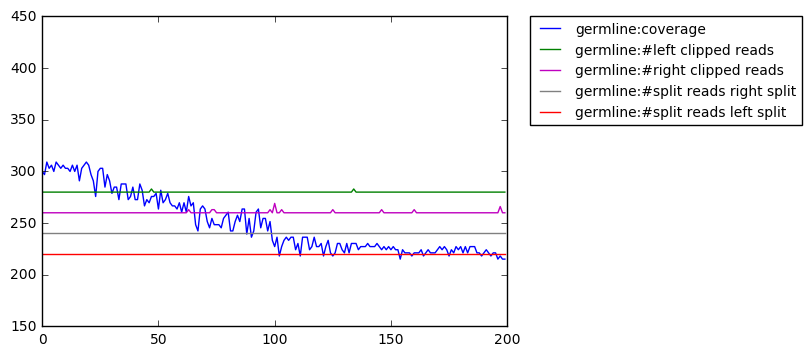

id: 47
Label: 0


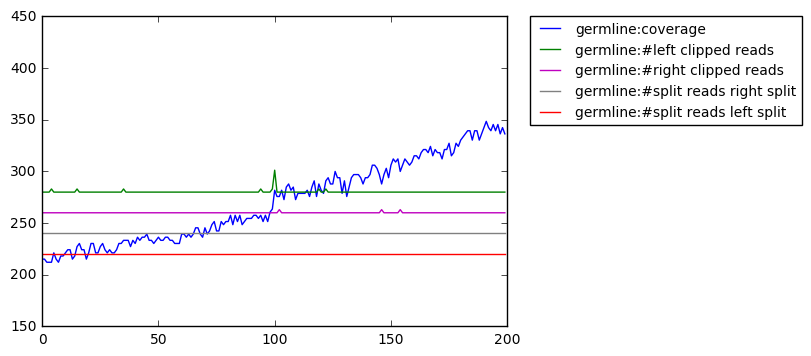

id: 48
Label: 1


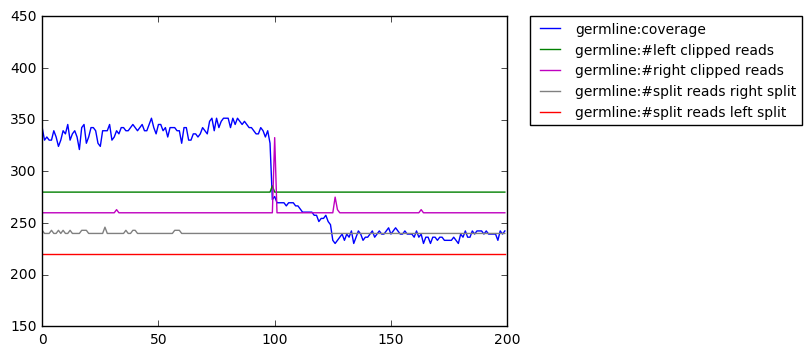

id: 49
Label: 1


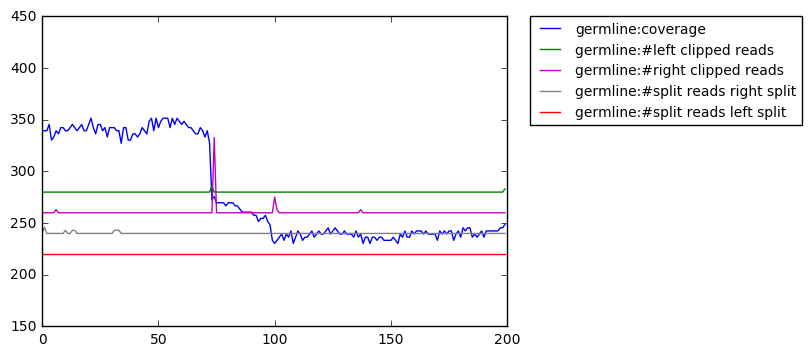

id: 50
Label: 0


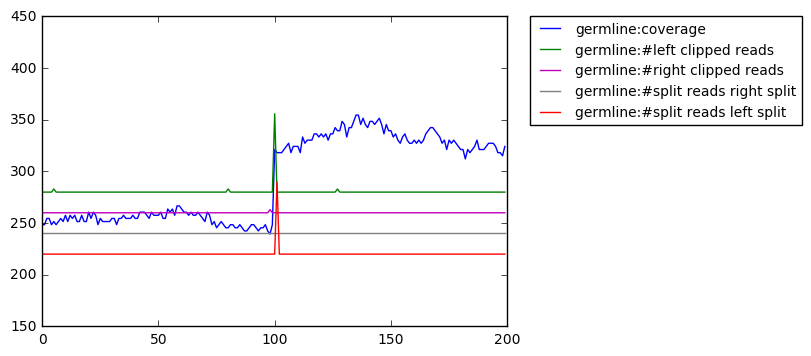

id: 51
Label: 1


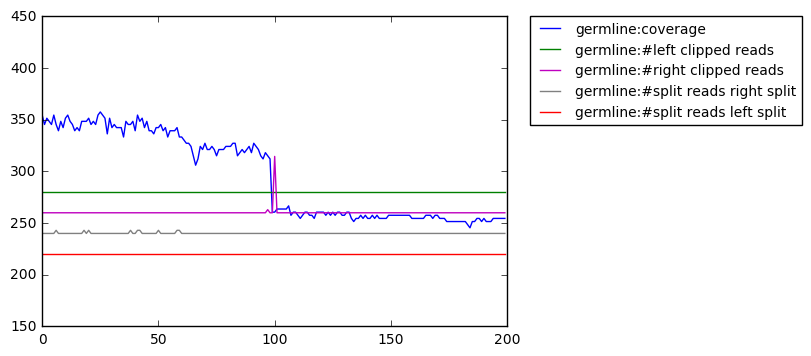

id: 52
Label: 0


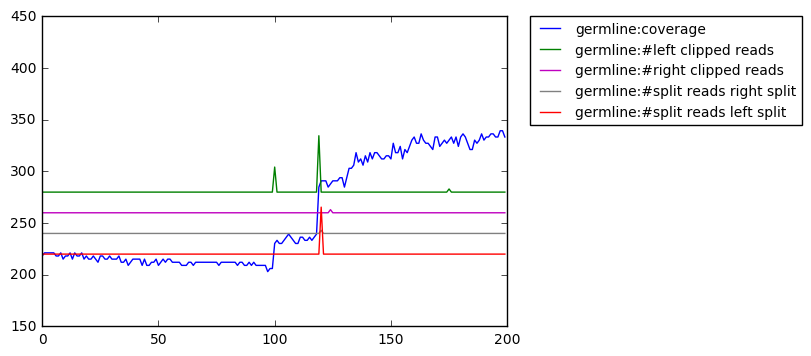

id: 53
Label: 0


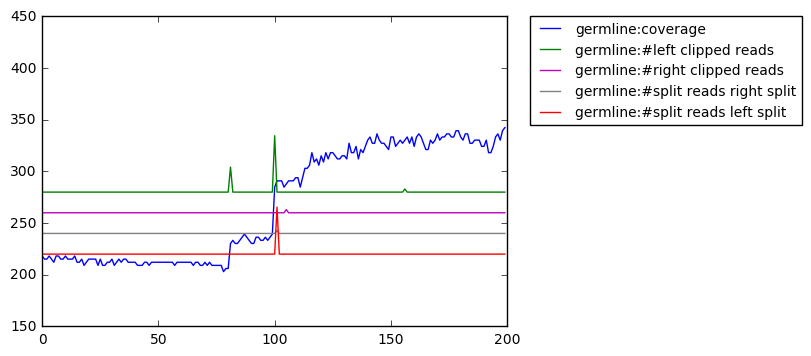

id: 54
Label: 1


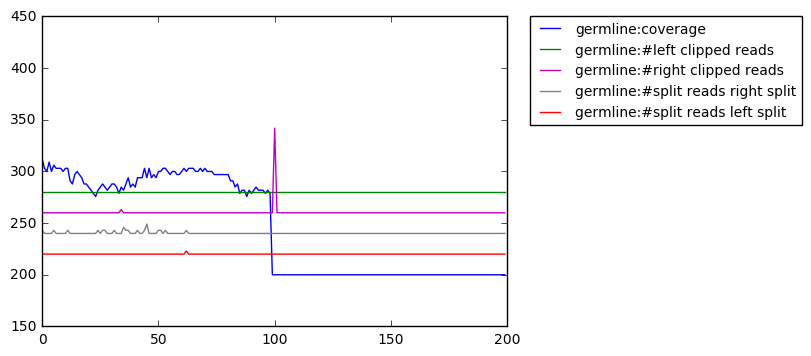

id: 55
Label: 0


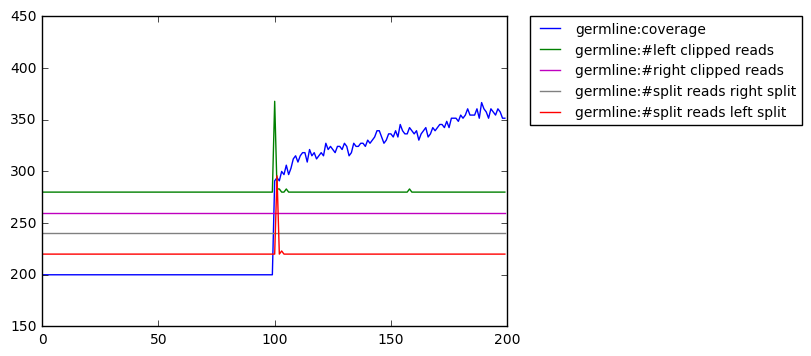

id: 56
Label: 1


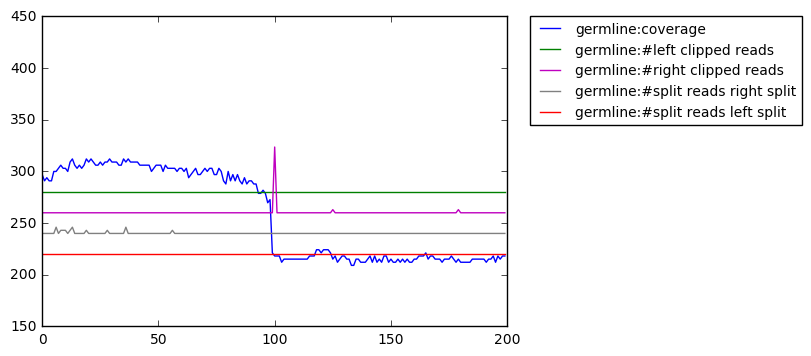

In [276]:
start_window = 0
n_windows = 57
plot_channels(start_window, n_windows)

id: 6000
Label: 2


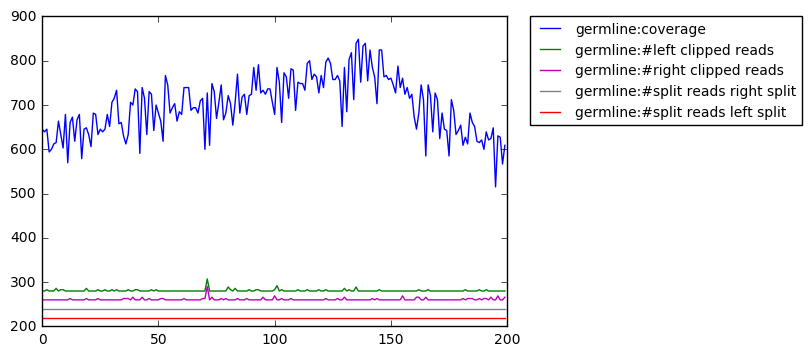

id: 6001
Label: 2


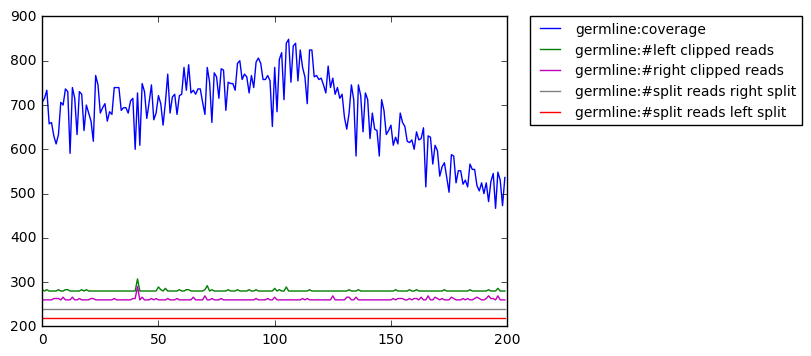

id: 6002
Label: 2


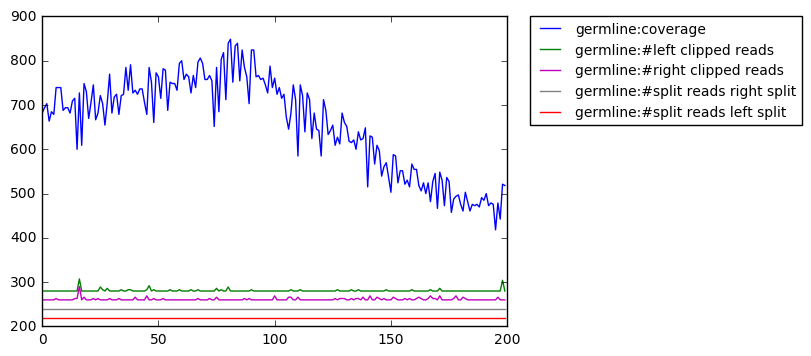

id: 6003
Label: 2


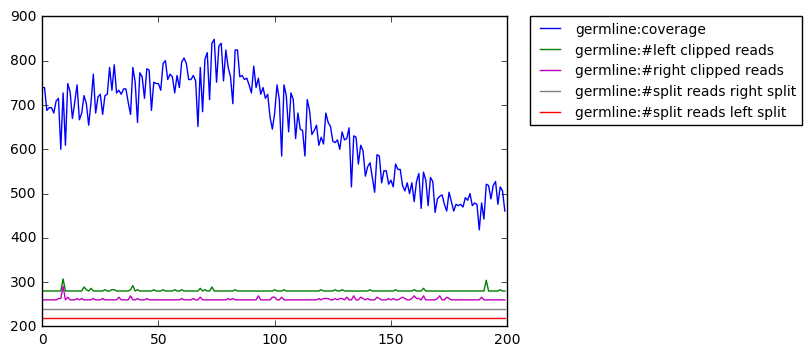

id: 6004
Label: 2


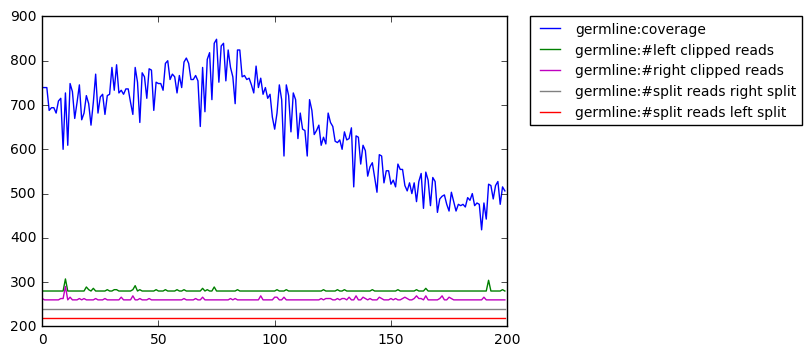

id: 6005
Label: 2


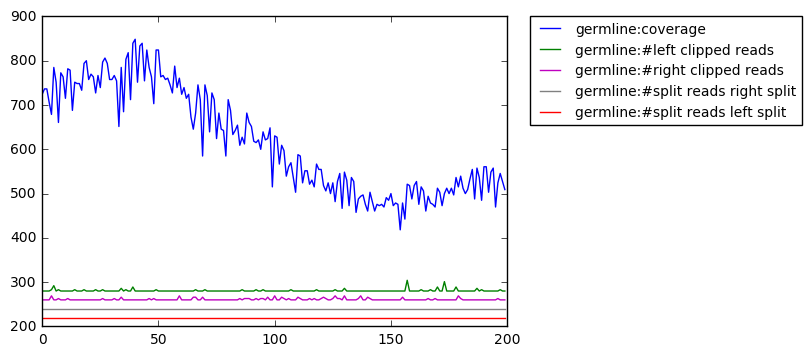

id: 6006
Label: 2


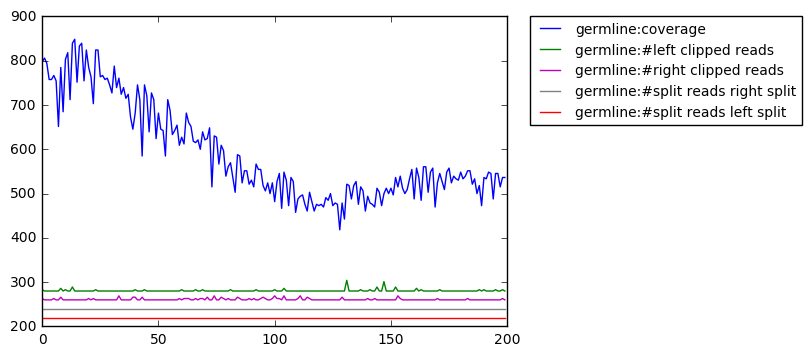

id: 6007
Label: 2


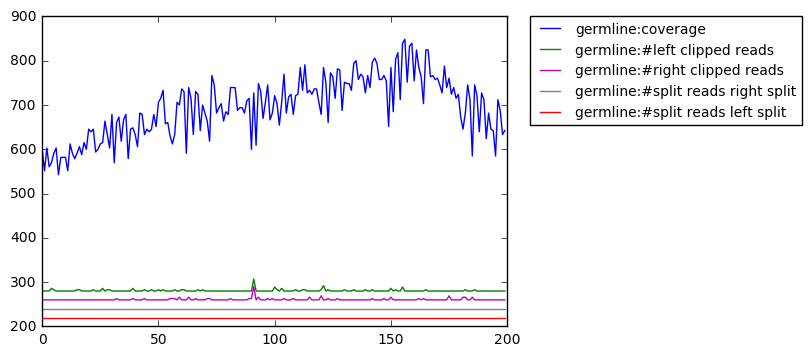

id: 6008
Label: 2


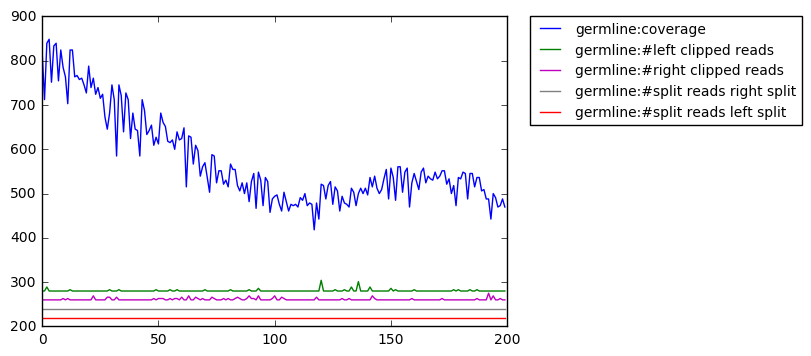

id: 6009
Label: 2


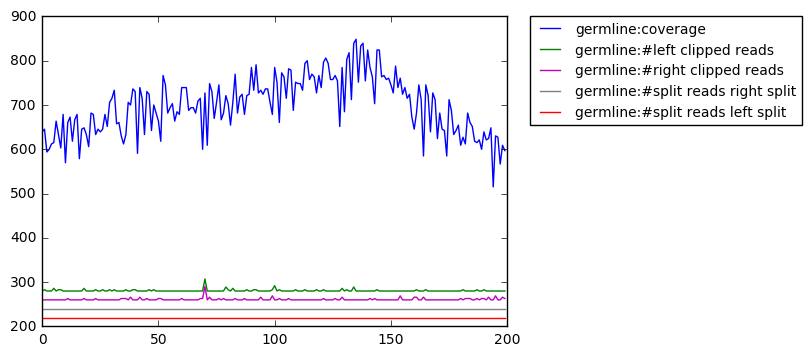

id: 6010
Label: 2


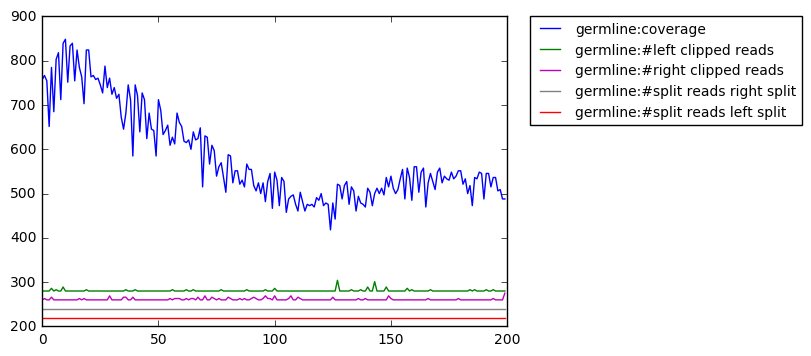

id: 6011
Label: 2


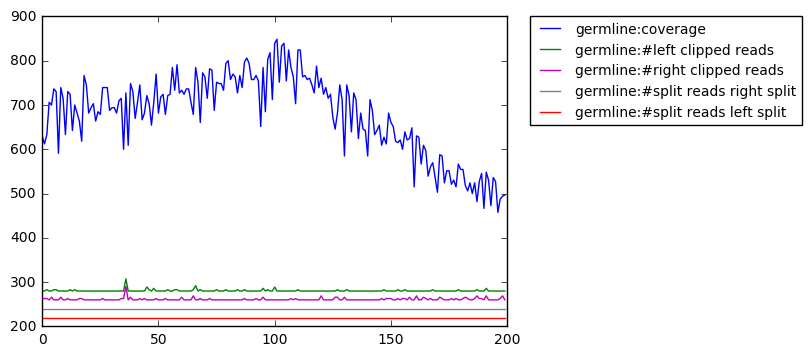

id: 6012
Label: 2


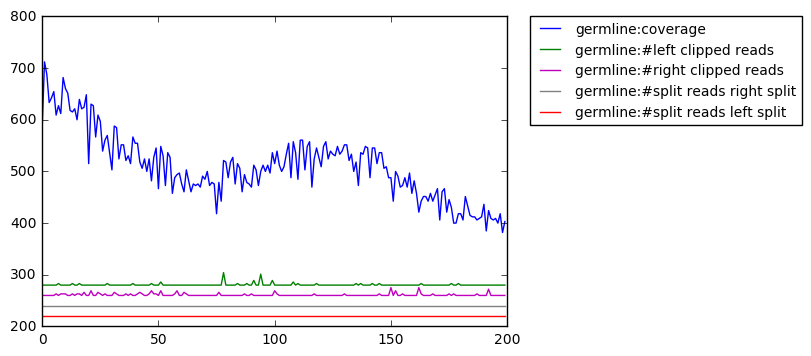

id: 6013
Label: 2


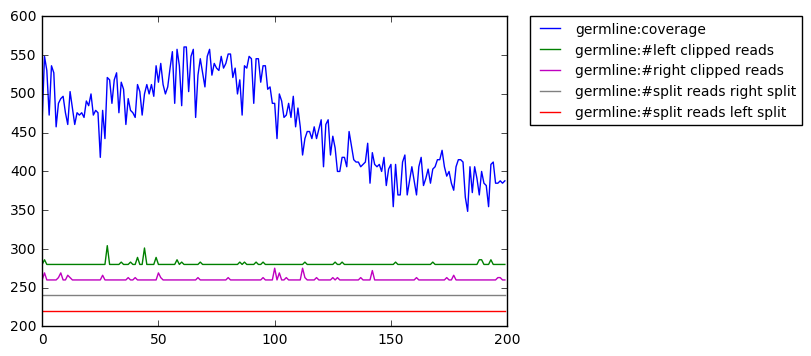

id: 6014
Label: 2


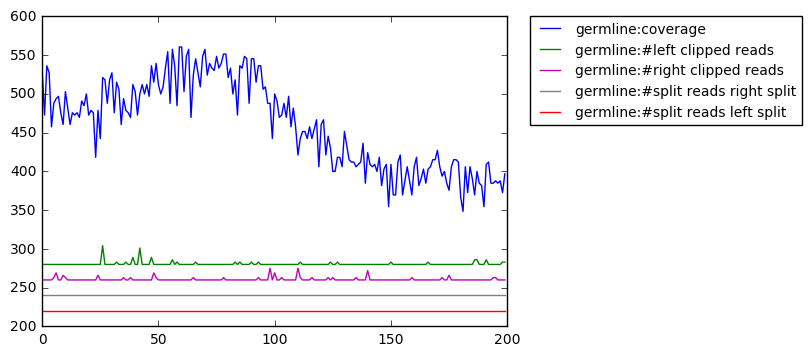

id: 6015
Label: 2


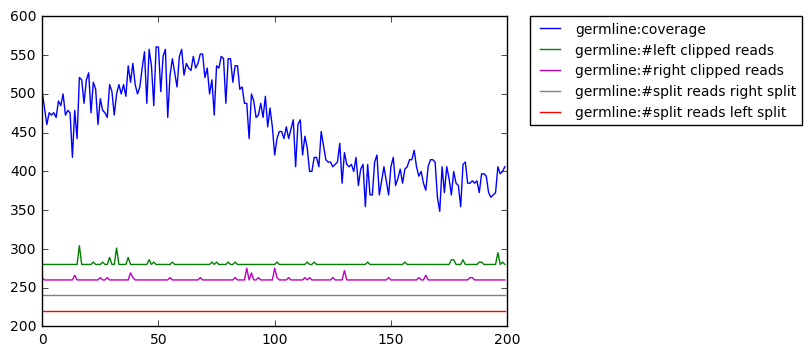

id: 6016
Label: 2


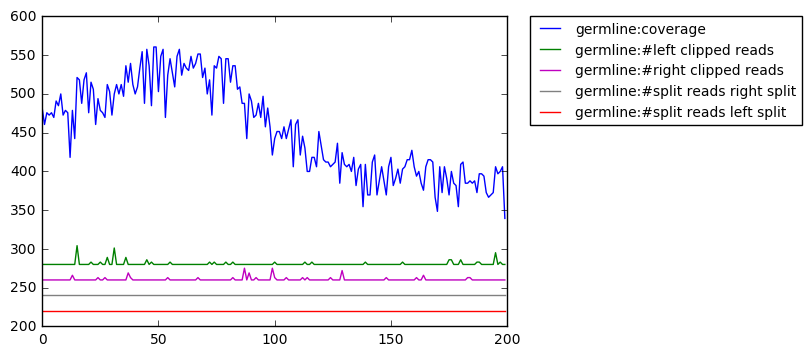

id: 6017
Label: 2


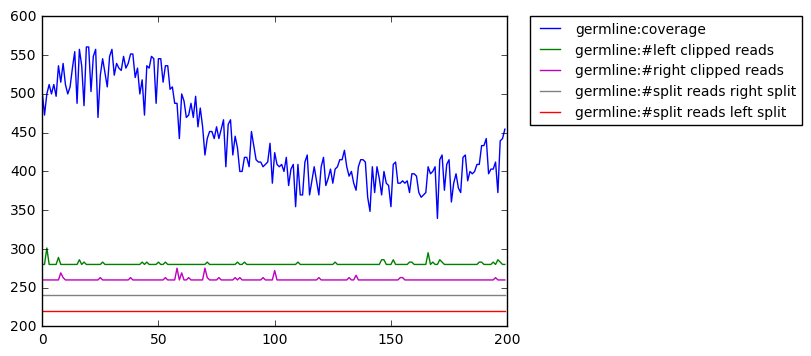

id: 6018
Label: 2


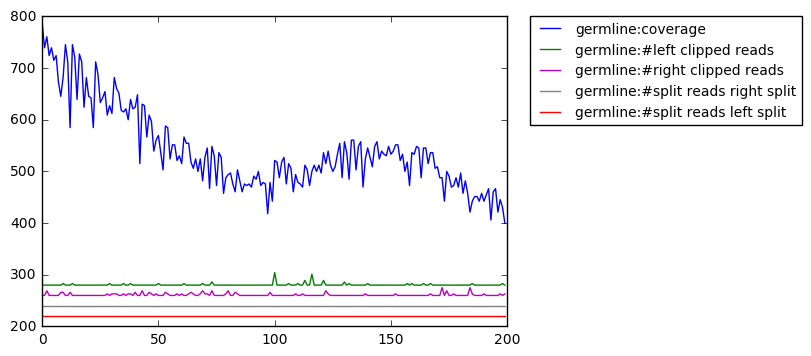

id: 6019
Label: 2


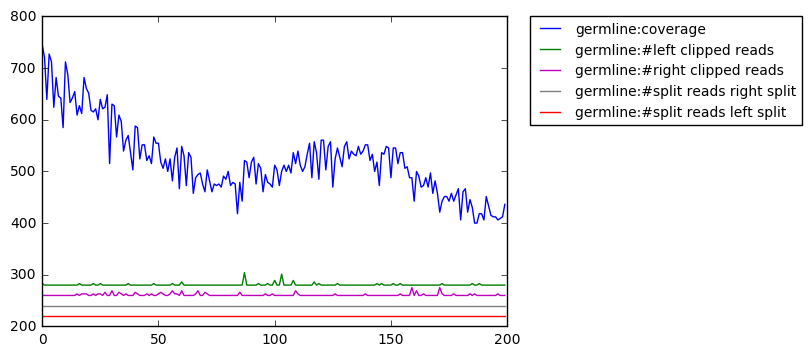

id: 6020
Label: 2


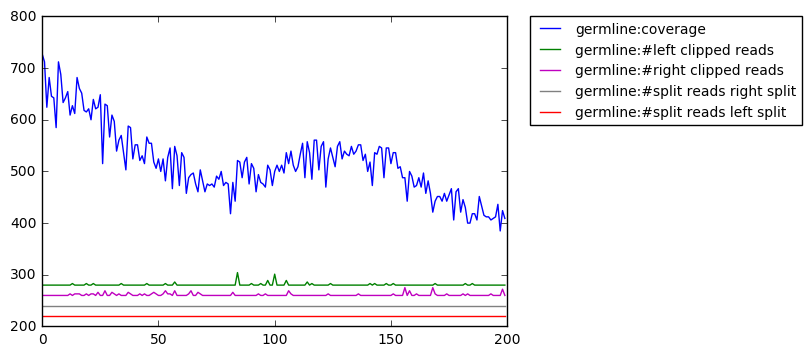

id: 6021
Label: 2


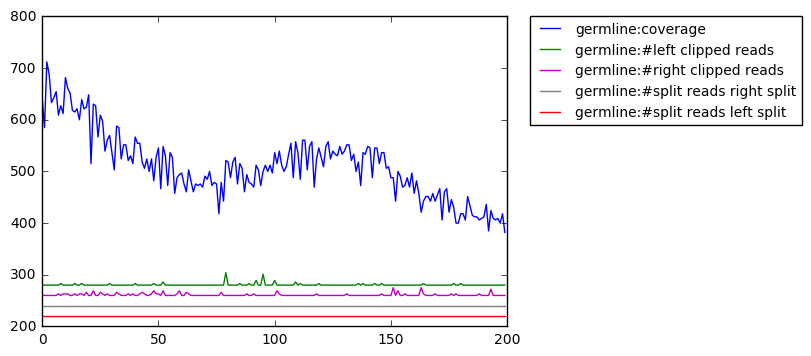

id: 6022
Label: 2


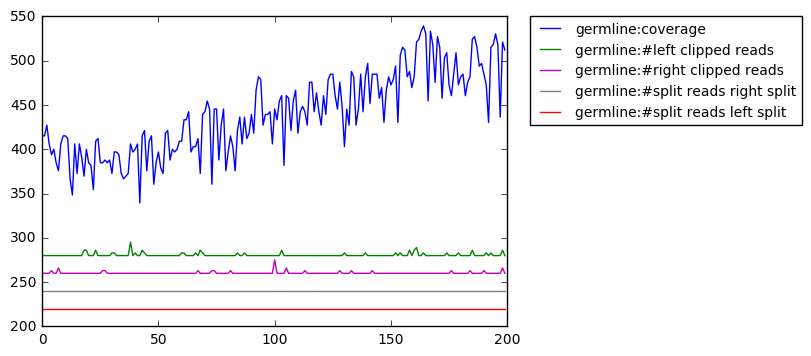

id: 6023
Label: 2


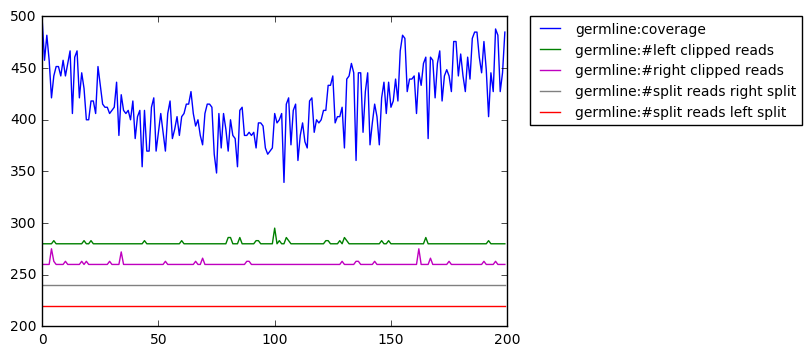

id: 6024
Label: 2


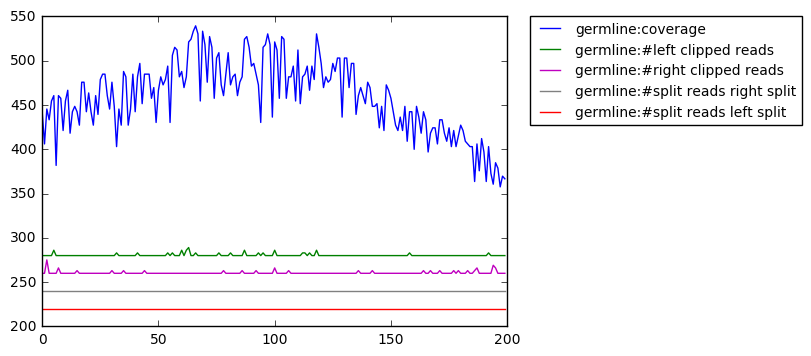

id: 6025
Label: 2


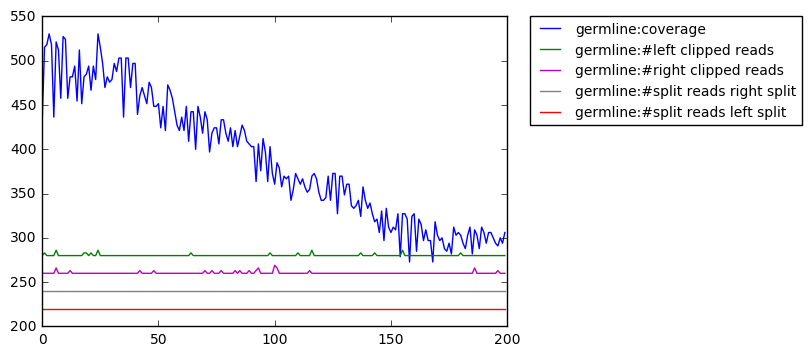

id: 6026
Label: 2


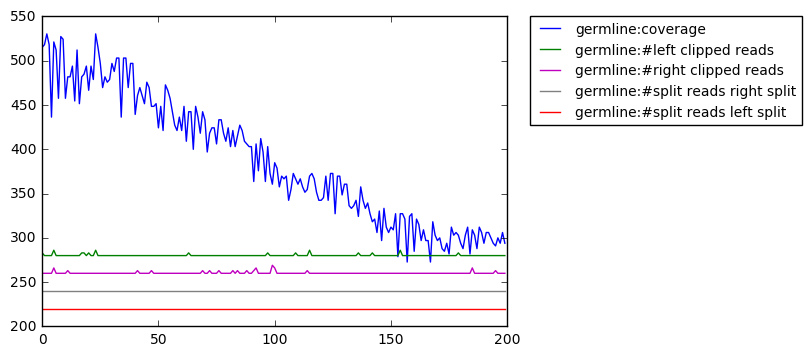

id: 6027
Label: 2


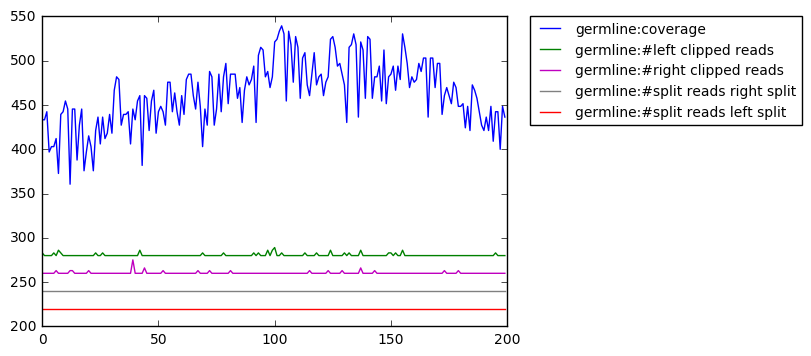

id: 6028
Label: 2


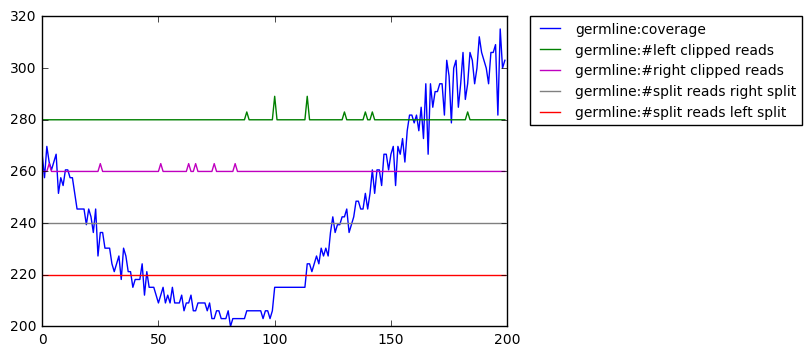

id: 6029
Label: 2


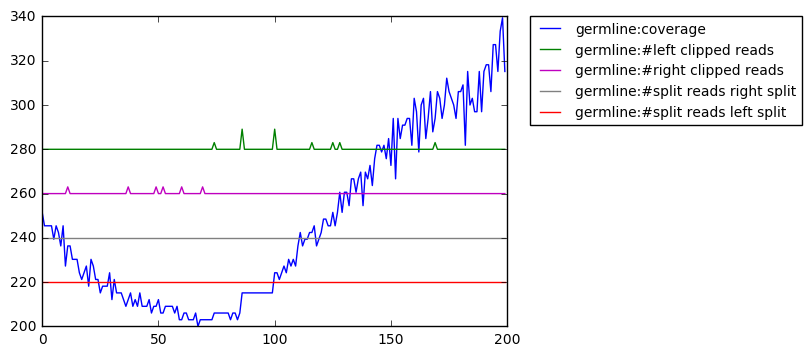

id: 6030
Label: 2


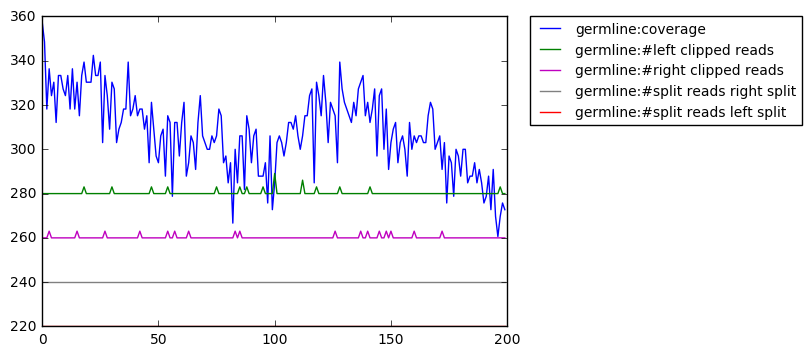

id: 6031
Label: 2


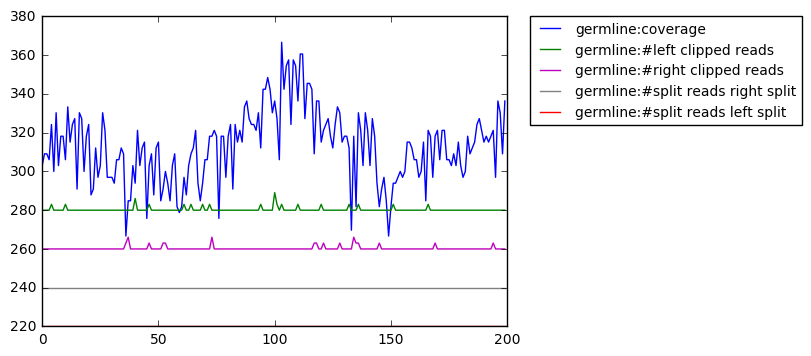

id: 6032
Label: 2


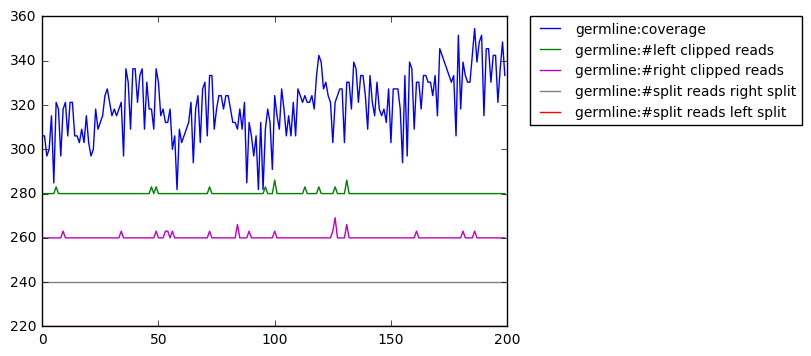

id: 6033
Label: 2


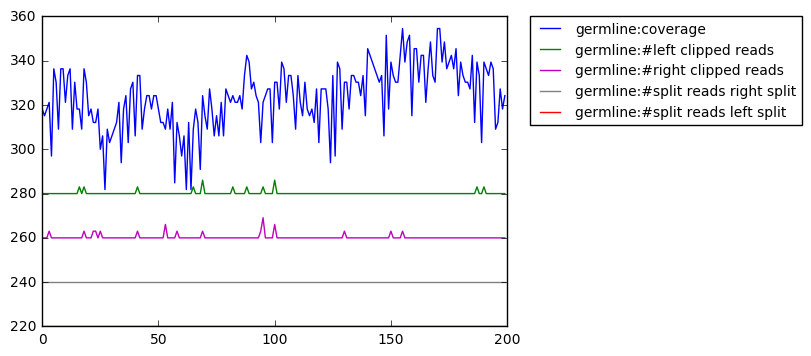

id: 6034
Label: 2


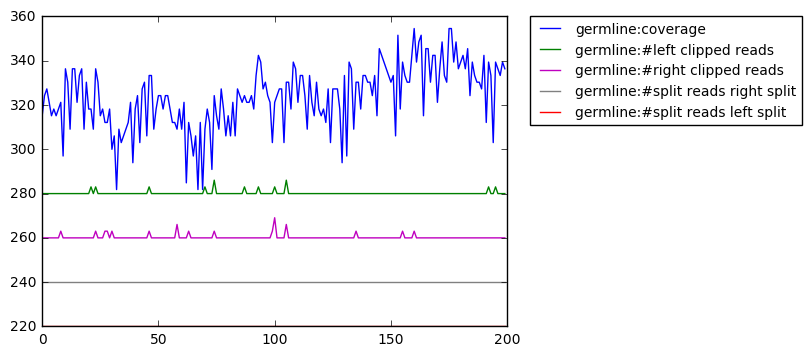

id: 6035
Label: 2


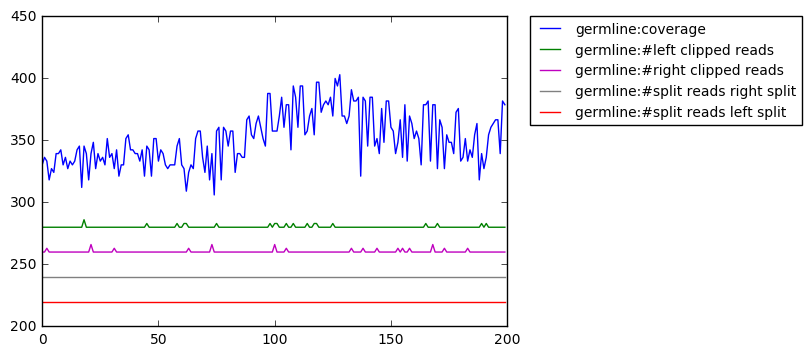

id: 6036
Label: 2


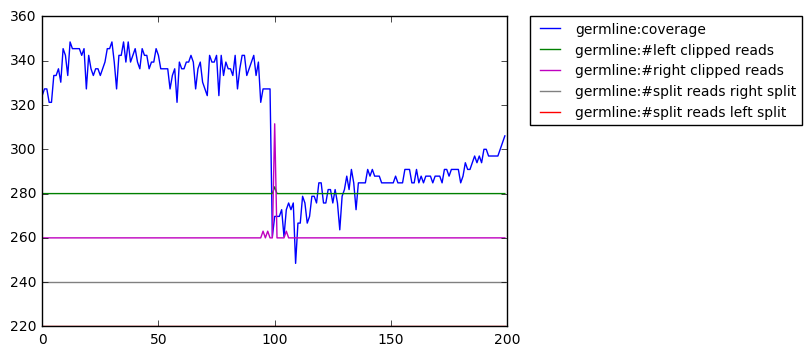

id: 6037
Label: 2


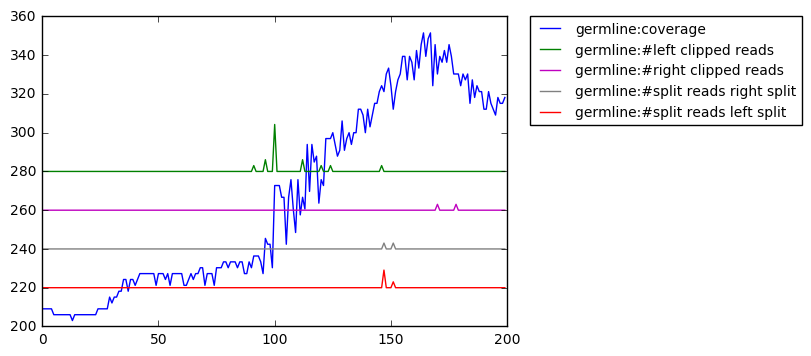

id: 6038
Label: 2


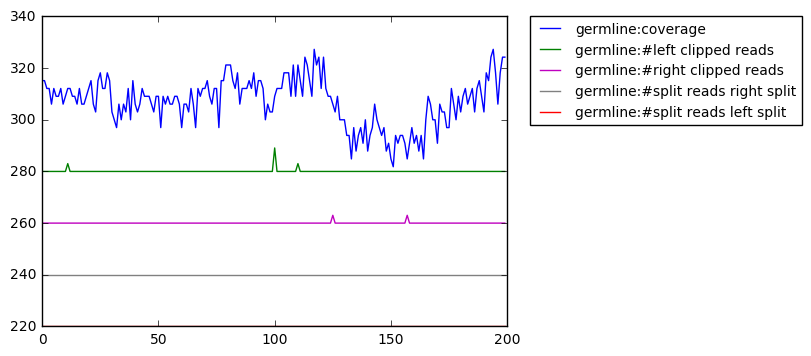

id: 6039
Label: 2


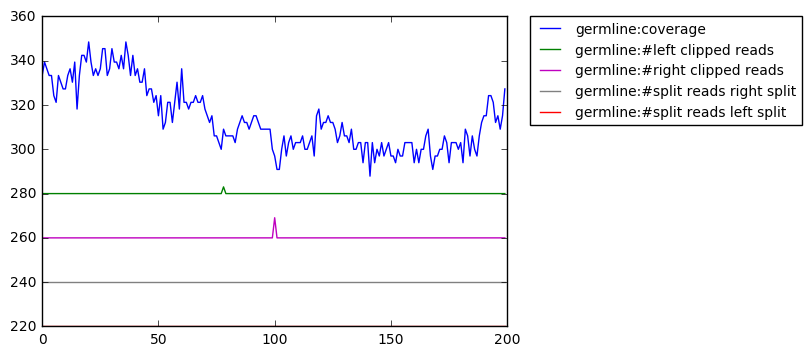

id: 6040
Label: 2


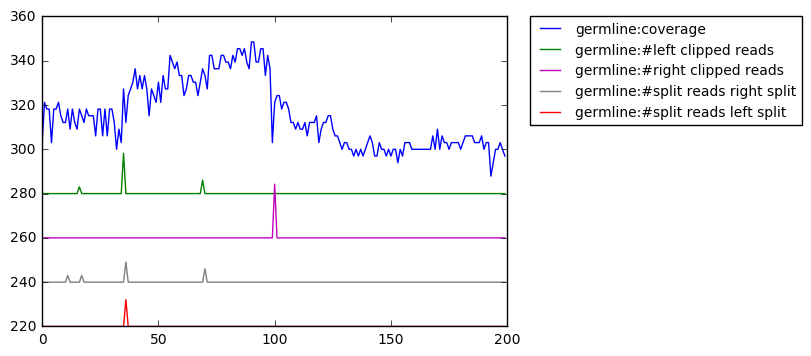

id: 6041
Label: 2


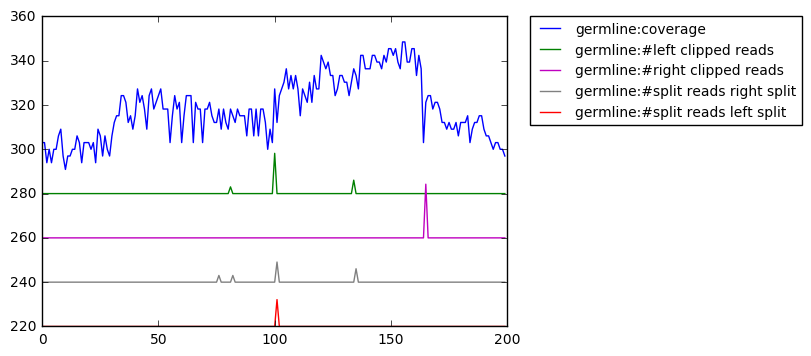

id: 6042
Label: 2


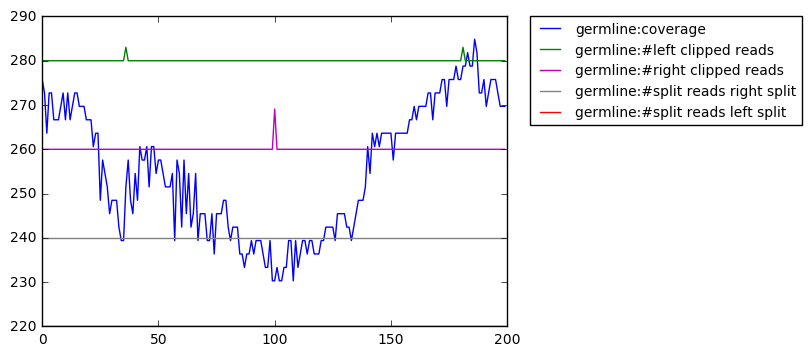

id: 6043
Label: 2


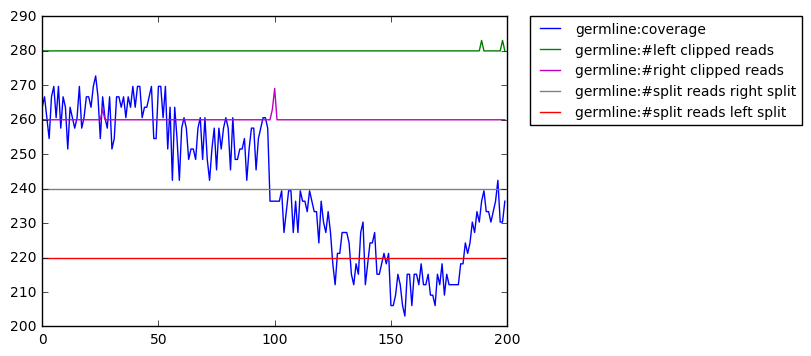

id: 6044
Label: 2


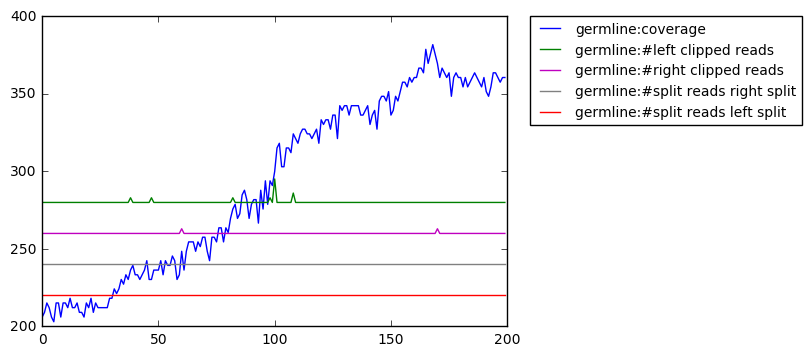

id: 6045
Label: 2


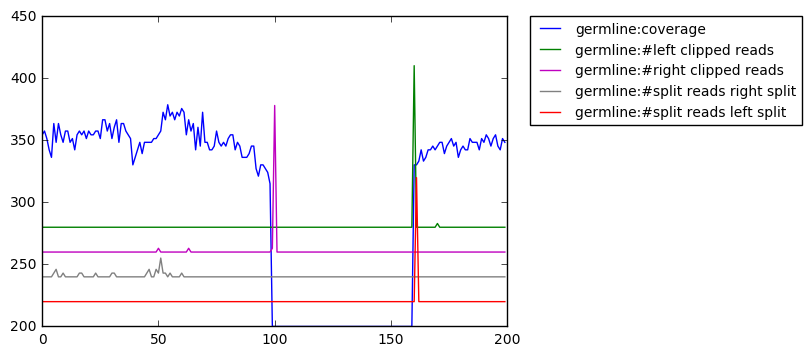

id: 6046
Label: 2


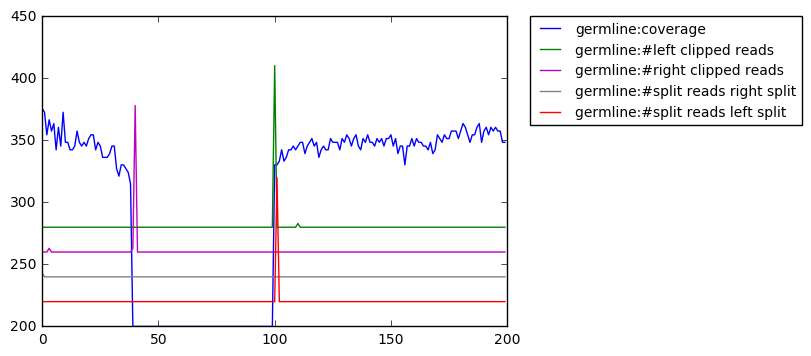

id: 6047
Label: 2


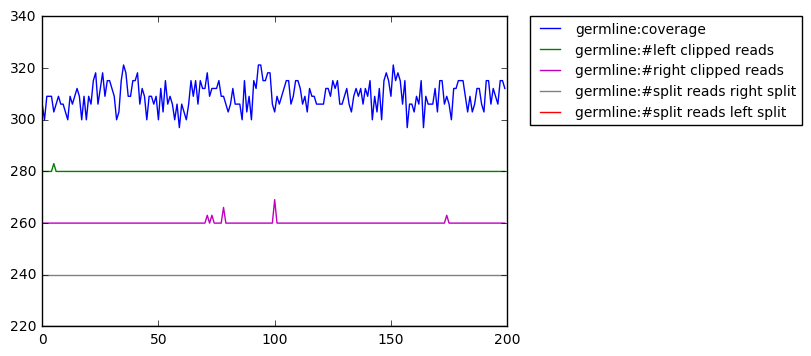

id: 6048
Label: 2


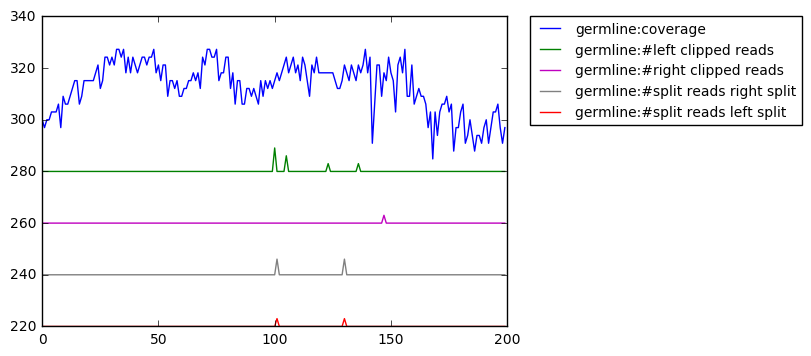

id: 6049
Label: 2


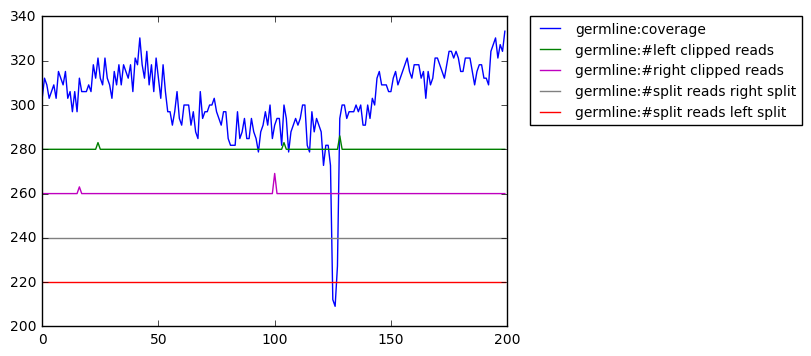

In [268]:
n_windows = 50
start_window = 6000
plot_channels(start_window, n_windows)

In [265]:
y_test[0]

1

In [266]:
X_test[0]

array([[ 154.54545455,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    3.03030303,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 157.57575758,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 163.63636364,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 157.57575758,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 166.66666667,    0.        ,    0.        ,    0.        ,    0.        ],
       [ 163.63636364,    0.        ,    0.        ,    3.03030303,    0.        ],
       [ 160.60606061,    0.        ,    0.        ,    0.        ,    0.   

   
## Transposes every window in X, to comply to McFly format

In [28]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

5


## Prepare the labels in McFly format

In [29]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'noSV': 2, 'DEL_start': 1, 'DEL_end': 0}


In [30]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [31]:
y_test_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [32]:
y_val_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [33]:
X_train.shape

(173533, 200, 5)

##  Generate and train neural networks 

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [35]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_filters = 3, 
                                  cnn_max_filters = 3, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=2,
                                  low_lr=1.73, high_lr=1.73,
                                  kernel_size = 11)

In [57]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=2,
                                  cnn_min_filters =2, 
                                  cnn_max_filters = 6, 
                                  cnn_min_fc_nodes=2, 
                                  cnn_max_fc_nodes=14,
                                  low_lr=1.9, high_lr=1.9,
                                  kernel_size = 7)

Wall time: 47.7 s


In [58]:
%%time
i=0
for model, params, model_types in models:
    print('model ' + str(i))
    i=i+1
    print(params)
    model.summary()

model 0
{'filters': array([4, 6]), 'fc_hidden_nodes': 6, 'learning_rate': 0.012589254117941675, 'regularization_rate': 0.00016919290422835856, 'kernel_size': 7}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_167 (Bat (None, 200, 5)            20        
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 200, 4)            144       
_________________________________________________________________
batch_normalization_168 (Bat (None, 200, 4)            16        
_________________________________________________________________
activation_167 (Activation)  (None, 200, 4)            0         
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 200, 6)            174       
_________________________________________________________________
batch_normalization_169 (Bat (None, 200, 6)    

In [59]:
train_set_size = X_train.shape[0]
train_set_size

173533

In [60]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=1, 
                                                                                 subset_size=train_set_size,
                                                                                 verbose=True)

Training model 0 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 665s 4ms/step - loss: 0.1301 - acc: 0.9726 - val_loss: 0.9448 - val_acc: 0.6933
Training model 1 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 578s 3ms/step - loss: 0.2180 - acc: 0.9544 - val_loss: 1.1762 - val_acc: 0.6791
Training model 2 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
173533/173533 [==============================] - 612s 4ms/step - loss: 0.1259 - acc: 0.9711 - val_loss: 0.2304 - val_acc: 0.9588
Training model 3 CNN
Train on 173533 samples, validate on 43456 samples
Epoch 1/1
149020/173533 [========================>.....] - ETA: 1:39 - loss: 0.2304 - acc: 0.9563

KeyboardInterrupt: 

## Save the best model

In [258]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

9 CNN {'learning_rate': 0.0199526231496888, 'kernel_size': 5, 'regularization_rate': 0.001029886001929122, 'filters': array([6]), 'fc_hidden_nodes': 8}


In [247]:
from keras.models import load_model

model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_')
best_model.save(model_path)

## Train the best model on the full dataset

In [248]:
#We make a copy of the model, to start training from fresh
nr_epochs = 1
datasize = train_set_size # Change in `X_train.shape[0]` if training complete data set
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              epochs=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 44725 samples, validate on 11200 samples
Epoch 1/1
44725/44725 [==============================] - 23s 509us/step - loss: 0.1315 - acc: 0.9715 - val_loss: 0.2120 - val_acc: 0.9294


## Reload the trained model

In [249]:
import os
from keras.models import load_model
#model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_26_10_16xoversample_NoDiff_9682')
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_30012019_9617')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [250]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [251]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [252]:
labels = [i[0] for i in dict_sorted]

In [253]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

DEL_end  DEL_start  noSV
DEL_end       2431         51    85
DEL_start       85       2618   221
noSV            23         86  2475

## Test best current model on testset

### Overall accuracy on the test set:

In [241]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.32894434823340307, 0.93597523219814238]
Wall time: 5.06 s
